<a href="https://colab.research.google.com/github/amadousysada/image-segmentation-phase2/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

L’objectif de ce notebook est de **comparer deux architectures de segmentation sémantique** sur nos images à **8 classes** (entrée **224×224×3**) :

* **U-Net** avec **backbone VGG16** (pré-entraîné ImageNet) — architecture « encodeur–décodeur » à *skip connections* pour une localisation fine. Réf. papier : *U-Net: Convolutional Networks for Biomedical Image Segmentation*. ([arXiv][1])
* **SegFormer** avec encodeur **MiT-B2** (preset `mit_b2_cityscapes_1024`) — *Transformer hiérarchique* (MiT) + décodeur **tout-MLP** léger, sans positional encoding, robuste aux changements de résolution. Réf. papier : *SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers*. ([arXiv][2])

Notre **protocole d’évaluation** s’appuie sur :

* **mean IoU (mIoU)** et **accuracy** globales,
* ainsi qu’une analyse **par classe** (IoU par classe) afin de juger la **détection des classes minoritaires** (p. ex. *human*, *object*).
  Nous contrôlons le **statut de pré-entraînement** et le **gel (freezing)** des encodeurs pour une comparaison la plus équitable possible.

**Pertes (losses) utilisées**

On note $p_{i,c}$ la probabilité prédite pour le **pixel** $i$ et la **classe** $c$, et $y_{i,c}\in\{0,1\}$ la vérité terrain (one-hot). La somme $\sum_i$ porte sur tous les pixels (éventuellement hors *ignore\_index*), et $\sum_c$ sur les classes.

1. **Dice Loss** (soft Dice, moyenne sur les classes)

$$
\mathrm{Dice}_c \;=\; \frac{2\sum_i p_{i,c}\,y_{i,c} + \varepsilon}{\sum_i p_{i,c} \;+\; \sum_i y_{i,c} \;+\; \varepsilon}\,,
\qquad
\mathcal{L}_{\mathrm{Dice}} \;=\; 1 \;-\; \frac{1}{C}\sum_{c=1}^{C}\mathrm{Dice}_c.
$$

2. **Focal Loss** (version multiclasses)

$$
\mathcal{L}_{\mathrm{Focal}} \;=\; -\,\frac{1}{N}\sum_{i}\sum_{c} \alpha_c\,y_{i,c}\,\bigl(1 - p_{i,c}\bigr)^{\gamma}\,\log\!\bigl(p_{i,c} + \varepsilon\bigr),
$$

avec $\gamma>0$ (focalisation) et $\alpha_c$ (poids de classe).

3. **Balanced Cross-Entropy** (CE pondérée par classe)

$$
\mathcal{L}_{\mathrm{BCE}} \;=\; -\,\frac{1}{N}\sum_{i}\sum_{c} w_c\,y_{i,c}\,\log\!\bigl(p_{i,c} + \varepsilon\bigr),
$$

où $w_c$ reflète le **déséquilibre** (p. ex. $w_c \propto 1/\mathrm{freq}_c$).

4. **Combined Loss** (pondération de deux termes)

$$
\mathcal{L}_{\mathrm{Combined}} \;=\; \lambda\,\mathcal{L}_{\mathrm{BCE}} \;+\; (1-\lambda)\,\mathcal{L}_{\mathrm{Dice}},
$$

avec $\lambda\in[0,1]$ (par défaut $\lambda=0{,}5$, ajustable).

> **Remarque métriques.** La **mIoU** est la moyenne des IoU par classe :

$$
\mathrm{IoU}_c=\frac{\mathrm{TP}_c}{\mathrm{TP}_c+\mathrm{FP}_c+\mathrm{FN}_c+\varepsilon},\qquad
\mathrm{mIoU}=\frac{1}{C}\sum_{c=1}^C \mathrm{IoU}_c.
$$

L’**accuracy** est la proportion de pixels correctement classés.

[1]: https://arxiv.org/abs/1505.04597 "Convolutional Networks for Biomedical Image Segmentation"
[2]: https://arxiv.org/abs/2105.15203 "SegFormer: Simple and Efficient Design for Semantic ..."


## Import des librairies

In [2]:
import time
init_time = time.time()

import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import register_keras_serializable

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import keras
# shell
#pip install -U keras keras-hub
import keras_hub
from keras_hub.models import MiTBackbone

# MLFLOW
!pip install mlflow==2.22.0 -q
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

from sklearn.metrics import confusion_matrix


print("Versions:")
print(f"{' '*2}- Numpy        =>: {np.__version__}")
print(f"{' '*2}- tensorflow   =>: {tf.__version__}")
print(f"{' '*2}- keras        =>: {tf.keras.__version__}")
print(f"{' '*2}- keras        =>: {keras.__version__}")
print(f"{' '*2}- keras_hub        =>: {keras_hub.__version__}")
print(f"{' '*2}- matplotlib   =>: {plt.matplotlib.__version__}")
print(f"{' '*2}- mlflow   =>: {mlflow.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 129.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 688.0/688.0 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.5 MB/s eta 0:00:00
Versions:
  - Numpy        =>: 2.0.2
  - t

In [3]:
base_path = "/content/drive/MyDrive/data/"
image_dir = os.path.join(base_path, "leftImg8bit")
mask_dir = os.path.join(base_path, "gtFine")

MLFLOW_TRACKING_URI = "https://mlflow.amadousy.dev"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploration

In [5]:
# Mapping des groupes vers la liste des classes Cityscapes correspondantes
"""
Sources:
  - https://raw.githubusercontent.com/mcordts/cityscapesScripts/master/cityscapesscripts/helpers/labels.py
  - https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
  - https://datasetninja.com/cityscapes
  - https://github.com/mcordts/cityscapesScripts
"""
CLASS_GROUPS = {
    "flat":        ["road", "sidewalk", "parking", "rail track"],
    "human":       ["person", "rider"],
    "vehicle":     ["car", "truck", "bus", "on rails", "motorcycle", "bicycle", "caravan", "trailer"],
    "construction":["building", "wall", "fence", "guard rail", "bridge", "tunnel"],
    "object":      ["pole", "pole group", "traffic sign", "traffic light"],
    "nature":      ["vegetation", "terrain"],
    "sky":         ["sky"],
    "void":        ["unlabeled", "ego vehicle", "ground", "rectification border", "out of roi", "dynamic", "static"]
}

GROUP_PALETTE = [
    (128, 64, 128),    # 0 - flat
    (220, 20, 60),     # 1 - human
    (0, 0, 142),       # 2 - vehicle
    (70, 70, 70),      # 3 - construction
    (220, 220, 0),     # 4 - object
    (107, 142, 35),    # 5 - nature
    (70, 130, 180),    # 6 - sky
    (0, 0, 0),         # 7 - void
]

group_cmap = ListedColormap(np.array(GROUP_PALETTE) / 255.0)

ordered_groups = list(CLASS_GROUPS.keys())

LABEL_ID_TO_NAME = {
    0: "unlabeled",
    1: "ego vehicle",
    2: "rectification border",
    3: "out of roi",
    4: "static",
    5: "dynamic",
    6: "ground",
    7: "road",
    8: "sidewalk",
    9: "parking",
    10: "rail track",
    11: "building",
    12: "wall",
    13: "fence",
    14: "guard rail",
    15: "bridge",
    16: "tunnel",
    17: "pole",
    18: "pole group",
    19: "traffic light",
    20: "traffic sign",
    21: "vegetation",
    22: "terrain",
    23: "sky",
    24: "person",
    25: "rider",
    26: "car",
    27: "truck",
    28: "bus",
    29: "caravan",
    30: "trailer",
    31: "on rails",
    32: "motorcycle",
    33: "bicycle",
}

NAME_TO_LABEL_ID = {v: k for k, v in sorted(LABEL_ID_TO_NAME.items())}

CLASS_MAP = {}
for group_idx, group_name in enumerate(ordered_groups):
    for class_name in CLASS_GROUPS[group_name]:
        cid = NAME_TO_LABEL_ID.get(class_name, -1)
        CLASS_MAP[cid] = group_idx


mapping = [7] * 34   # initialisé à 7 (void)
for orig_id, new_id in CLASS_MAP.items():
    mapping[orig_id] = new_id

In [6]:
tf.constant(mapping, dtype=tf.int32)

<tf.Tensor: shape=(34,), dtype=int32, numpy=
array([7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5,
       5, 6, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)>

### Focal Crop

In [7]:
def _ensure_3d_mask(mask):
    return tf.expand_dims(mask, -1) if tf.rank(mask) == 2 else mask

def _pad_if_needed(img, msk, min_h, min_w):
    H = tf.shape(img)[0]; W = tf.shape(img)[1]
    pad_h = tf.maximum(min_h - H, 0)
    pad_w = tf.maximum(min_w - W, 0)
    if pad_h > 0 or pad_w > 0:
        ph1 = pad_h // 2; ph2 = pad_h - ph1
        pw1 = pad_w // 2; pw2 = pad_w - pw1
        img = tf.pad(img, [[ph1, ph2], [pw1, pw2], [0, 0]], constant_values=0)
        msk = tf.pad(msk, [[ph1, ph2], [pw1, pw2], [0, 0]], constant_values=0)
    return img, msk

def _random_crop_pair(img, msk, ch, cw, oy, ox):
    return (
        tf.image.crop_to_bounding_box(img, oy, ox, ch, cw),
        tf.image.crop_to_bounding_box(msk, oy, ox, ch, cw),
    )

def _random_offsets_around(y, x, ch, cw, H, W):
    y_min = tf.maximum(y - ch + 1, 0)
    y_max = tf.minimum(y, H - ch)
    x_min = tf.maximum(x - cw + 1, 0)
    x_max = tf.minimum(x, W - cw)

    def rint(lo, hi):  # inclusive
        return tf.random.uniform([], minval=lo, maxval=hi + 1, dtype=tf.int32)

    oy = tf.cond(y_min <= y_max, lambda: rint(y_min, y_max), lambda: 0)
    ox = tf.cond(x_min <= x_max, lambda: rint(x_min, x_max), lambda: 0)
    return oy, ox

def random_focal_crop(image, mask, crop_size=(256, 256), p_focal=0.7, focus_classes=None):
    ch = tf.cast(crop_size[0], tf.int32)
    cw = tf.cast(crop_size[1], tf.int32)

    img = tf.convert_to_tensor(image)
    msk = tf.convert_to_tensor(mask)
    msk = tf.cast(msk, tf.int32)
    msk3 = _ensure_3d_mask(msk)

    # pad si besoin
    img, msk3 = _pad_if_needed(img, msk3, ch, cw)
    H = tf.shape(img)[0]; W = tf.shape(img)[1]

    # foreground
    msk2d = tf.squeeze(msk3, axis=-1)
    if focus_classes is None:
        fg = tf.not_equal(msk2d, 0)
    else:
        focus = tf.stack([tf.equal(msk2d, tf.cast(c, tf.int32)) for c in focus_classes], axis=-1)
        fg = tf.reduce_any(focus, axis=-1)

    fg_idx = tf.cast(tf.where(fg), tf.int32)  # [N,2] (y,x)
    has_fg = tf.greater(tf.shape(fg_idx)[0], 0)

    def do_focal():
        ridx = tf.random.uniform([], 0, tf.shape(fg_idx)[0], dtype=tf.int32)
        y, x = fg_idx[ridx][0], fg_idx[ridx][1]
        oy, ox = _random_offsets_around(y, x, ch, cw, H, W)
        return _random_crop_pair(img, msk3, ch, cw, oy, ox)

    def do_random():
        oy = tf.random.uniform([], 0, H - ch + 1, dtype=tf.int32)
        ox = tf.random.uniform([], 0, W - cw + 1, dtype=tf.int32)
        return _random_crop_pair(img, msk3, ch, cw, oy, ox)

    use_focal = tf.logical_and(has_fg, tf.less(tf.random.uniform([]), p_focal))
    img_c, msk_c = tf.cond(use_focal, do_focal, do_random)
    return img_c, tf.squeeze(msk_c, axis=-1)

### DataGenerator

In [8]:
def augment_data(image, mask):
    # flip horizontal aléatoire
    if tf.random.uniform(()) > 0.5:
      image = tf.image.flip_left_right(image)
      mask  = tf.image.flip_left_right(mask[..., tf.newaxis])[..., 0]
    # légère variation de contraste
    image = tf.image.random_contrast(image, 0.8, 1.2)
    # légère variation de luminosité
    image = tf.image.random_brightness(image, 0.1)
    image = tf.clip_by_value(image, 0, 1)
    return image, mask


def build_dataset(
    img_paths, mask_paths,
    image_size=(224, 224),
    data_type="train",
    batch_size=32,
    validation_split=0.3,
    augment=False,
    shuffle=False,
    use_focal_crop=False,
    focal_crop_size=None,
    p_focal=0.7,
    focus_classes=None
    ):
  ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))

  if focal_crop_size is None:
        focal_crop_size = image_size

  def _old_load(i, m):
    img = tf.image.decode_png(tf.io.read_file(i), channels=3)
    mask = tf.image.decode_png(tf.io.read_file(m), channels=1)
    img = tf.image.resize(img, image_size, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.image.resize(mask, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.int32)

    mask = tf.gather(tf.constant(mapping, dtype=tf.int32), mask)

    return img, mask
  def _load(i, m):
        # lire
        img = tf.image.decode_png(tf.io.read_file(i), channels=3)          # uint8
        msk = tf.image.decode_png(tf.io.read_file(m), channels=1)          # uint8 [H,W,1]

        # mapping labelIds -> classes internes AVANT le focal crop (pour détecter le FG correct)
        msk = tf.squeeze(tf.cast(msk, tf.int32), axis=-1)                  # [H,W]
        mapping_tf = tf.constant(mapping, dtype=tf.int32)
        msk = tf.gather(mapping_tf, msk)                                   # [H,W] ints mappés

        # focal crop (sur taille native), sinon on travaillera sur l'image complète
        if use_focal_crop:
            img, msk = random_focal_crop(
                image=img,
                mask=msk,
                crop_size=focal_crop_size,
                p_focal=p_focal,
                focus_classes=focus_classes
            )

        # resize vers image_size final (si focal_crop_size != image_size)
        img = tf.image.resize(img, image_size, method=tf.image.ResizeMethod.BILINEAR)
        msk = tf.image.resize(msk[..., tf.newaxis], image_size,
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)[..., 0]

        # normalisation
        img = tf.cast(img, tf.float32) / 255.0
        msk = tf.cast(msk, tf.int32)
        return img, msk

  ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(buffer_size=1024)

  if augment:
    ds = ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return ds

def make_dataset(
    image_size=(224, 224),
    data_type="train",
    batch_size=32,
    validation_split=0.0,
    augment=False,
    shuffle=False,
    use_focal_crop=False,
    focal_crop_size=None,
    p_focal=0.7,
    focus_classes=None
    ):
  images_path = []
  masks_path = []

  for city in os.listdir(f"{image_dir}/{data_type}"):
    image_path = os.path.join(image_dir, data_type, city)
    mask_path = os.path.join(mask_dir, data_type, city)
    for image in os.listdir(image_path):
      if image.endswith("_leftImg8bit.png"):
        base = image.replace("_leftImg8bit.png", "")
        mask = base + "_gtFine_labelIds.png"
        if os.path.exists(os.path.join(mask_path, mask)):
          images_path.append(os.path.join(image_path, image))
          masks_path.append(os.path.join(mask_path, mask))

  if data_type == "train" and validation_split > 0:
      n = len(images_path)
      split_idx = int((1 - validation_split) * n)
      train_imgs, val_imgs = images_path[:split_idx], images_path[split_idx:]
      train_msks, val_msks = masks_path[:split_idx], masks_path[split_idx:]

      train_ds = build_dataset(
          train_imgs, train_msks, image_size, batch_size,
          shuffle=shuffle,
          augment=augment,
          use_focal_crop=use_focal_crop,
          focal_crop_size=focal_crop_size,
          p_focal=p_focal,
          focus_classes=focus_classes
          )
      val_ds   = build_dataset(val_imgs, val_msks, image_size, batch_size)
      return train_ds, val_ds
  else:
      return build_dataset(
          images_path, masks_path, image_size, batch_size,
          shuffle=shuffle,
          augment=augment,
          use_focal_crop=use_focal_crop,
          focal_crop_size=focal_crop_size,
          p_focal=p_focal,
          focus_classes=focus_classes
          )

In [9]:
def show_vertical_legend(palette, labels, ax):
    """
    Affiche une légende verticale (groupe/couleur).
    palette : liste de couleurs RGB [(R,G,B), ...]
    labels : liste des noms de groupes (même taille que palette)
    """
    # Créer les patches (légendes)
    patches = [
        mpatches.Patch(color=np.array(rgb)/255.0, label=label)
        for rgb, label in zip(palette, labels)
    ]

    # Afficher la légende verticalement à gauche
    ax.legend(handles=patches, loc='center left', bbox_to_anchor=(0, 0.5),
              frameon=False, fontsize=10)
    ax.axis('off')
    plt.tight_layout()

def plot_sample(ds, figsize=(14, 6), title=""):
  for imgs, masks in ds.take(1):
    idx = np.random.choice(range(0,32))
    img = imgs[idx]
    mask = masks[idx]

    plt.figure(figsize=figsize)
    ax= plt.subplot(1, 4, 1)
    ax.imshow(img)
    plt.title("Image")
    plt.axis("off")

    ax = plt.subplot(1, 4, 2)
    ax.imshow(mask, cmap=group_cmap, interpolation='nearest', vmin=0, vmax=len(GROUP_PALETTE)-1)
    plt.title("Mask")
    plt.axis("off")

    ax = plt.subplot(1, 4, 3)
    mask_arr = mask.numpy()
    unique_classes, counts = np.unique(mask_arr, return_counts=True)
    percentages = counts / mask_arr.size * 100
    group_names = [ordered_groups[i] for i in unique_classes]

    ax.pie(percentages, labels=group_names, autopct="%1.1f%%", startangle=90, colors=group_cmap.colors, textprops={'color': 'white'})
    ax.axis("equal")
    ax.set_title("Répartition des groupes dans le mask")
    plt.axis("equal")
    plt.suptitle("Test de l'echantillon train", fontsize=16)

    ax = plt.subplot(1, 4, 4)
    show_vertical_legend(GROUP_PALETTE, ordered_groups, ax)
    plt.show()


def display_prediction(image, original_mask, pred_mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(original_mask, cmap=group_cmap, interpolation='nearest', vmin=0, vmax=len(GROUP_PALETTE)-1)
    plt.title("Mask originale")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask, cmap=group_cmap, interpolation='nearest', vmin=0, vmax=len(GROUP_PALETTE)-1)
    plt.title("Mask prédit")
    plt.axis("off")

    ax = plt.subplot(1, 4, 4)
    show_vertical_legend(GROUP_PALETTE, ordered_groups, ax)

    plt.show()


def plot_confusion_matrix(model, dataset):
    """
    Génère et affiche une matrice de confusion pixel-wise.

    Args:
        model: le modél à evaluer
        dataset: les données sur lesquelles evaluées le modél
    """

    y_trues = []
    y_preds = []

    # Boucle sur tout le jeu de test
    for imgs, masks in dataset:
        # imgs : (batch, H, W, 3),
        # masks : (batch, H, W, 1)

        preds = model.predict(imgs) # (batch, H, W, C)

        preds_arg = np.argmax(preds, axis=-1) # (batch, H, W)

        # Obtenir la vérité terrain en enlevant le canal unique
        # Vérité terrain (B,H,W) ou (B,H,W,1) -> (B,H,W)
        if masks.shape.rank == 4 and masks.shape[-1] == 1:
            true_idx = tf.squeeze(masks, axis=-1).numpy().astype(np.int32)
        else:
            true_idx = masks.numpy().astype(np.int32)

        y_preds.append(preds_arg)
        y_trues.append(true_idx)

    # Concaténer tous les batches et aplatir en vecteur 1-D
    y_pred = np.concatenate([p.flatten() for p in y_preds], axis=0)
    y_true = np.concatenate([t.flatten() for t in y_trues], axis=0)

    print("y_true shape:", y_true.shape, "y_pred shape:", y_pred.shape)

    class_names = list(CLASS_GROUPS.keys())

    num_classes = len(class_names)

    totals = np.bincount(y_true, minlength=num_classes)
    corrects = np.bincount(y_true[y_true == y_pred], minlength=num_classes)
    accuracies = corrects / totals * 100

    df_summary = pd.DataFrame({
        "Group": class_names,
        "Total Pixels": totals,
        "Correct Pixels": corrects,
        "Accuracy (%)": accuracies
    })

    # Calcul de la matrice
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

    # Affichage
    fig, ax = plt.subplots(figsize=(18, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    # Ticks et labels
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel='Vérité terrain',
        xlabel='Prédictions'
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Annotation des cases
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:,}",
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax.set_title("Matrice de confusion (pixels)")
    fig.tight_layout()
    plt.show()

    return df_summary

### Split des données

In [10]:
%%time
train_ds, validation_ds = make_dataset(data_type="train", batch_size=32, validation_split=0.2, augment=True, use_focal_crop=True, focal_crop_size=(384, 384), p_focal=0.7, focus_classes=[1, 4])
test_ds = make_dataset(data_type="val", batch_size=32, use_focal_crop=True, focal_crop_size=(384, 384), p_focal=0.7, focus_classes=[1, 4])
test_wo_mask_ds = make_dataset(data_type="test", batch_size=32, use_focal_crop=True, focal_crop_size=(384, 384), p_focal=0.7, focus_classes=[1, 4]) # Dataset test sans mask utilisé pour des test de validation visuelle(humaine)

CPU times: user 1.87 s, sys: 364 ms, total: 2.23 s
Wall time: 31.4 s


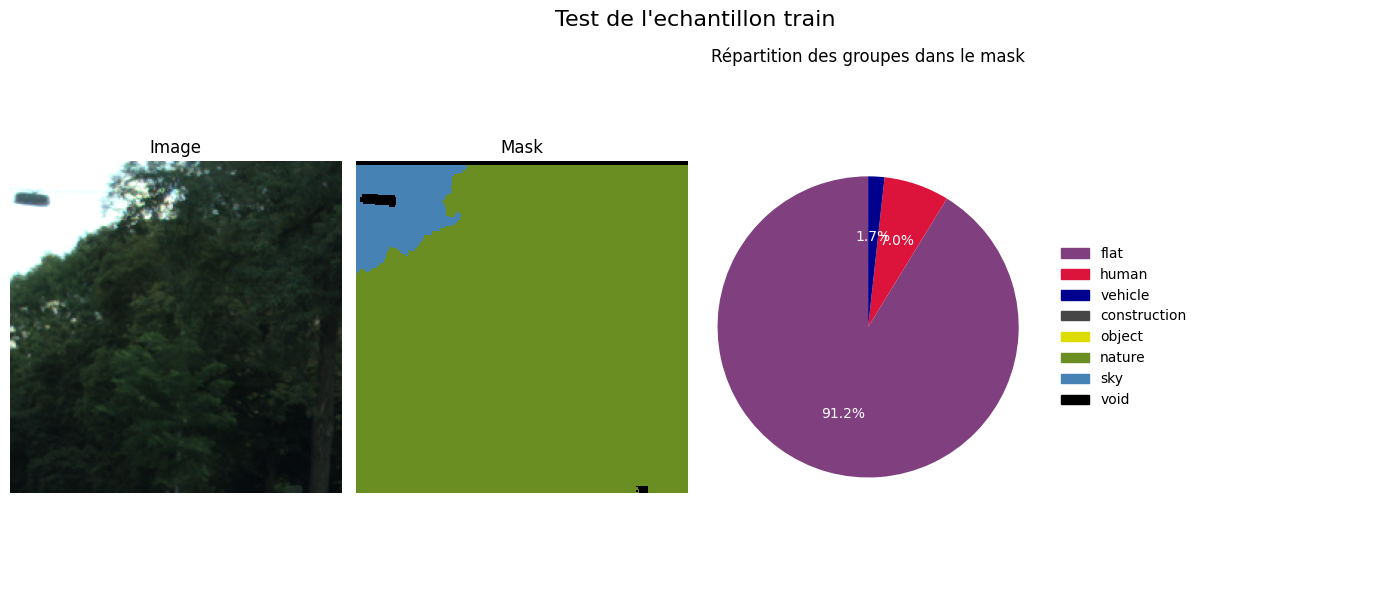

CPU times: user 6.8 s, sys: 310 ms, total: 7.11 s
Wall time: 6.58 s


In [11]:
%%time
plot_sample(train_ds, title="Test de l'echantillon train")

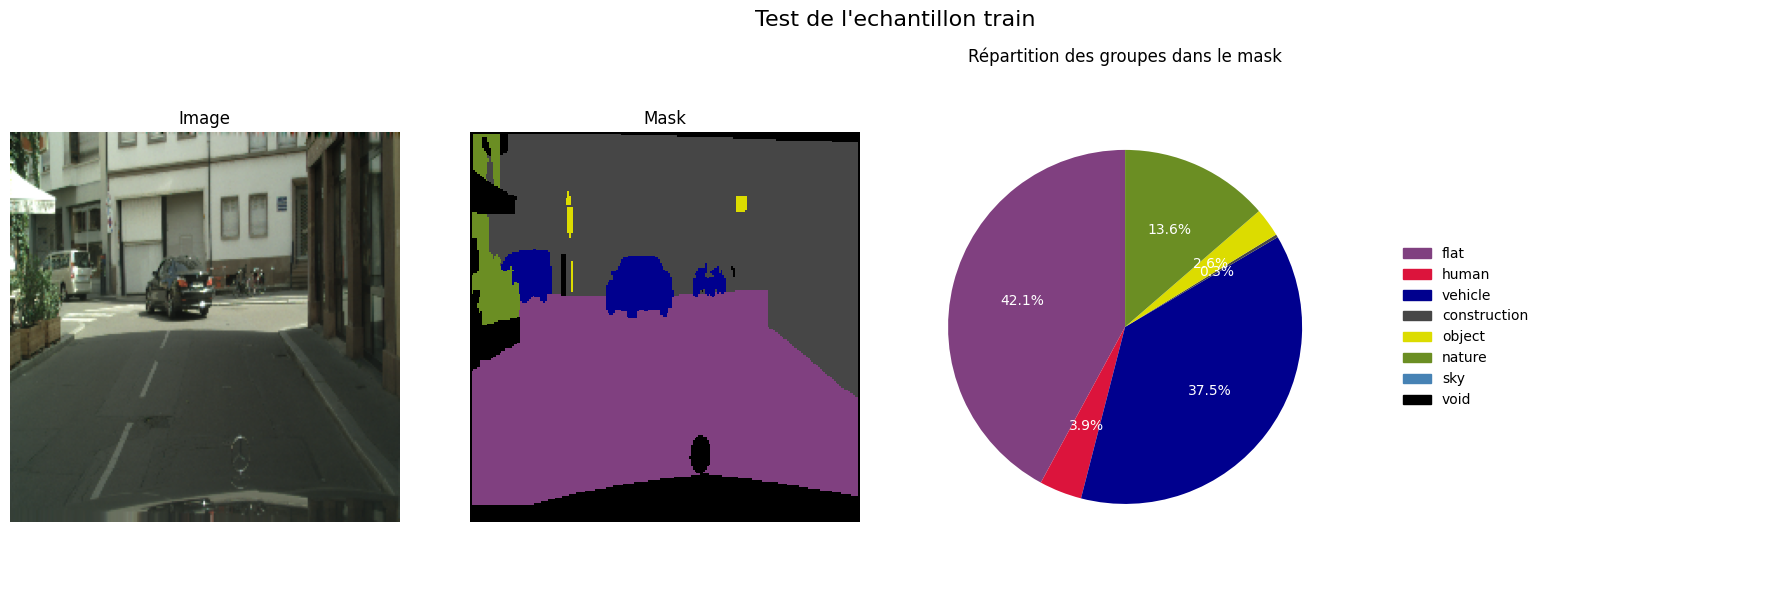

CPU times: user 4.48 s, sys: 115 ms, total: 4.6 s
Wall time: 5.05 s


In [12]:
%%time
plot_sample(validation_ds, title="Test de l'echantillon validation", figsize=(18, 6))

### Augmentation des données

In [13]:
train_ds_no_aug, _ = make_dataset(data_type="train", batch_size=32, validation_split=0.2, augment=False)
train_ds_aug, _ = make_dataset(data_type="train", batch_size=32, validation_split=0.2, augment=True)

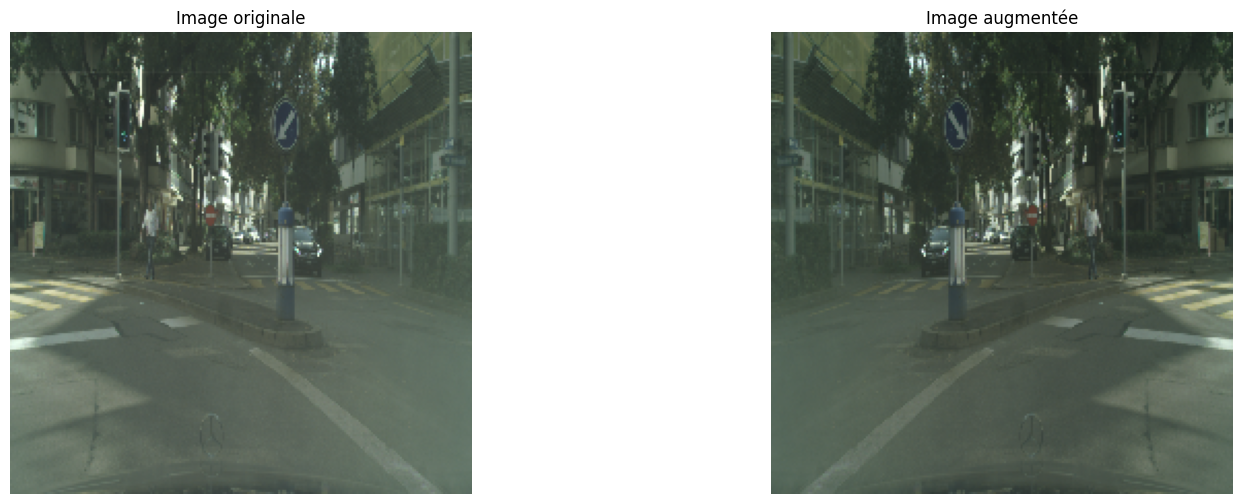

In [14]:
for (imgs, _), (imgs_aug, _) in zip(train_ds_aug.take(1), train_ds_no_aug.take(1)):
    idx = np.random.choice(range(0,32))
    img = imgs[idx]
    img_aug = imgs_aug[idx]

    plt.figure(figsize=(18, 6))
    ax= plt.subplot(1, 2, 1)
    ax.imshow(img)
    plt.title("Image originale")
    plt.axis("off")

    ax = plt.subplot(1, 2, 2)
    ax.imshow(img_aug)
    plt.title("Image augmentée")
    plt.axis("off")
    plt.show()

# Modélisation

### Metrics & Loss functions

**Metrcis**:
* MeanIoU
* Accuracy

In [15]:
class MeanIoUArgmax(tf.keras.metrics.MeanIoU):
    """Custom MeanIoU metric that applies argmax to predictions"""
    def __init__(self, num_classes, name="mean_io_u_argmax", **kwargs):
        super().__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_pred : (batch, H, W, num_classes) → take the winning class
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)



**Loss functions:**
* Dice Loss
* Focal Loss
* Combined Loss
* balanced_cross_entropy

In [16]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice Loss for semantic segmentation

    Args:
        y_true: Ground truth masks (batch_size, H, W)
        y_pred: Predicted logits (batch_size, H, W, num_classes)
        smooth: Smoothing factor to avoid division by zero

    Returns:
        Dice loss value
    """
    # Convert predictions to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot encoding
    num_classes = tf.shape(y_pred)[-1]
    y_true = tf.cast(y_true, tf.int32)
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Flatten tensors
    y_true_flat = tf.reshape(y_true_one_hot, [-1, num_classes])
    y_pred_flat = tf.reshape(y_pred, [-1, num_classes])

    # Calculate Dice coefficient for each class
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
    union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)

    dice_coeff = (2. * intersection + smooth) / (union + smooth)

    # Return 1 - mean Dice coefficient as loss
    return 1 - tf.reduce_mean(dice_coeff)


def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal Loss for addressing class imbalance

    Args:
        y_true: Ground truth masks (batch_size, H, W)
        y_pred: Predicted logits (batch_size, H, W, num_classes)
        alpha: Weighting factor for rare class
        gamma: Focusing parameter

    Returns:
        Focal loss value
    """
    # Convert to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot encoding
    num_classes = tf.shape(y_pred)[-1]
    y_true = tf.cast(y_true, tf.int32)
    if y_true.shape.rank == 4 and masks.shape[-1] == 1:
      y_true = tf.squeeze(y_true, axis=-1)

    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Calculate cross entropy
    ce_loss = -y_true_one_hot * tf.math.log(tf.clip_by_value(y_pred, 1e-8, 1.0))

    # Calculate focal weight
    p_t = y_true_one_hot * y_pred
    alpha_t = y_true_one_hot * alpha
    focal_weight = alpha_t * tf.pow(1 - p_t, gamma)

    # Apply focal weight
    focal_loss = focal_weight * ce_loss

    return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))


def combined_loss(y_true, y_pred, dice_weight=0.5, ce_weight=0.5):
    """
    Combined Dice + Cross-Entropy Loss

    Args:
        y_true: Ground truth masks
        y_pred: Predicted logits
        dice_weight: Weight for dice loss
        ce_weight: Weight for cross-entropy loss

    Returns:
        Combined loss value
    """
    dice = dice_loss(y_true, y_pred)
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    ce = tf.reduce_mean(ce)

    return dice_weight * dice + ce_weight * ce


def balanced_cross_entropy(y_true, y_pred, class_weights=None):
    """
    Balanced Cross-Entropy Loss with class weights

    Args:
        y_true: Ground truth masks
        y_pred: Predicted logits
        class_weights: Optional class weights tensor

    Returns:
        Weighted cross-entropy loss
    """
    if class_weights is None:
        # Default weights for Cityscapes (8 classes)
        class_weights = tf.constant([0.5, 2.0, 2.0, 1.0, 1.5, 3.0, 1.0, 0.1])

    # Convert to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot
    num_classes = tf.shape(y_pred)[-1]
    y_true = tf.cast(y_true, tf.int32)
    if y_true.shape.rank == 4 and masks.shape[-1] == 1:
      y_true = tf.squeeze(y_true, axis=-1)
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Calculate weighted cross entropy
    ce_loss = -y_true_one_hot * tf.math.log(tf.clip_by_value(y_pred, 1e-8, 1.0))
    weighted_ce = ce_loss * class_weights

    return tf.reduce_mean(tf.reduce_sum(weighted_ce, axis=-1))

### Architecture

In [17]:
def conv_block(x, filters, kernel_size=3, activation='relu', batch_norm=True):
    """Basic convolutional block with optional batch normalization"""
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x


def encoder_block(x, filters, pool_size=2):
    """Encoder block for U-Net: conv + conv + maxpool"""
    skip = conv_block(x, filters)
    skip = conv_block(skip, filters)
    x = layers.MaxPooling2D(pool_size)(skip)
    return x, skip


def decoder_block(x, skip, filters):
    """Decoder block for U-Net: upsample + concat + conv + conv"""
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    return x

def vgg16_unet(input_shape=(224, 224, 3), num_classes=8, freeze_encoder=True):
    """
    U-Net with VGG16 pretrained backbone

    Args:
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        freeze_encoder: Whether to freeze the encoder weights

    Returns:
        Keras Model
    """
    # Load pretrained VGG16 as encoder
    vgg16 = tf.keras.applications.VGG16(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    if freeze_encoder:
        vgg16.trainable = False

    # Extract skip connections from VGG16
    skip1 = vgg16.get_layer('block1_conv2').output    # 224x224, 64
    skip2 = vgg16.get_layer('block2_conv2').output    # 112x112, 128
    skip3 = vgg16.get_layer('block3_conv3').output    # 56x56, 256

    # Bottleneck (center of U-Net)
    bottleneck = vgg16.get_layer('block4_conv3').output  # 28x28, 512
    x = conv_block(bottleneck, 1024)
    x = conv_block(x, 1024)

    # Decoder with skip connections
    # Upsample and concatenate with skip3
    x = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x)  # 56x56
    x = layers.Concatenate()([x, skip3])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    # Upsample and concatenate with skip2
    x = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x)  # 112x112
    x = layers.Concatenate()([x, skip2])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    # Upsample and concatenate with skip1
    x = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x)   # 224x224
    x = layers.Concatenate()([x, skip1])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    # Final classification layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', name='segmentation_output')(x)

    model = Model(vgg16.input, outputs, name='VGG16_UNet')
    return model

def build_mit_pyramid_extractor(preset="mit_b0_ade20k_512", load_weights=True):
    """
    Expose les 4 features pyramidales (output_level_0..3) du backbone MiT.
    L'input du modèle retourné correspond à celui du preset (ex. 512x512).
    """
    mit = MiTBackbone.from_preset(preset, load_weights=load_weights)
    names = [f"output_level_{i}" for i in range(4)]
    feats = [mit.get_layer(n).output for n in names]   # 1/4, 1/8, 1/16, 1/32
    return Model(mit.input, feats, name="mit_pyramid_extractor")

def segformer_decoder(features, num_classes, decoder_dim=256, depth=0, name="segformer_decoder"):
    f1, f2, f3, f4 = features  # 1/4, 1/8, 1/16, 1/32

    def proj(x):
        x = layers.Conv2D(decoder_dim, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        return layers.Activation("relu")(x)

    p1, p2, p3, p4 = proj(f1), proj(f2), proj(f3), proj(f4)
    p2u = layers.UpSampling2D(2, interpolation="bilinear")(p2)
    p3u = layers.UpSampling2D(4, interpolation="bilinear")(p3)
    p4u = layers.UpSampling2D(8, interpolation="bilinear")(p4)

    x = layers.Concatenate()([p1, p2u, p3u, p4u])
    for _ in range(depth):
        x = layers.Conv2D(decoder_dim, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

    logits_1_4 = layers.Conv2D(num_classes, 1, padding="same", name=f"{name}_logits_1_4")(x)
    return logits_1_4

def segformer_keras(input_shape=(224, 224, 3), num_classes=8,
                    pretraining='imagenet',                  # 'imagenet' ou 'none'
                    mit_preset='mit_b0_ade20k_512',          # ou 'mit_b2_ade20k_512' pour plus gros
                    decoder_dim=256, decoder_depth=0,
                    freeze_encoder=True,
                    name="SegFormer"):
    load_w = (pretraining == 'imagenet')

    # 1) Extracteur pyramidal (preset, ex. 512x512)
    mit_feats = build_mit_pyramid_extractor(preset=mit_preset, load_weights=load_w)
    if freeze_encoder:
        mit_feats.trainable = False   # gèle tout le backbone (patch+stages+LN)

    Hm, Wm = mit_feats.input_shape[1:3]   # ex. (512, 512)

    # 2) Entrée utilisateur 224² → resize vers taille attendue par MiT
    inputs = layers.Input(shape=input_shape)
    x_in   = layers.Resizing(Hm, Wm, interpolation="bilinear", name="resize_to_mit")(inputs)

    f1, f2, f3, f4 = mit_feats(x_in)      # 1/4..1/32 (sur base Hm×Wm)

    # 3) Décodeur MLP → logits à 1/4 (Hm/4 × Wm/4), puis upsample à Hm×Wm
    logits_1_4   = segformer_decoder([f1, f2, f3, f4], num_classes=num_classes,
                                     decoder_dim=decoder_dim, depth=decoder_depth)
    logits_full  = layers.UpSampling2D(4, interpolation="bilinear", name="upsample_to_mit")(logits_1_4)

    # 4) Revenir à 224² et softmax
    logits_224   = layers.Resizing(input_shape[0], input_shape[1], interpolation="bilinear",
                                   name="resize_to_input")(logits_full)
    outputs      = layers.Activation("softmax", name="segmentation_output")(logits_224)
    return Model(inputs, outputs, name=name)


def create_model(model_type='vgg16_unet', input_shape=(224, 224, 3), num_classes=8, **kwargs):
    """
    Factory function to create different model architectures

    Args:
        model_type: Type of model ('unet_mini', 'vgg16_unet', 'resnet50_unet')
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        **kwargs: Additional model-specific arguments

    Returns:
        Keras Model
    """
    if model_type == 'vgg16_unet':
        return vgg16_unet(input_shape, num_classes, **kwargs)
    elif model_type == 'segformer':
        return segformer_keras(input_shape=input_shape, num_classes=num_classes, **kwargs)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

def get_loss_function(loss_type='cross_entropy'):
    """
    Get loss function by name

    Args:
        loss_type: Type of loss function

    Returns:
        Loss function
    """
    if loss_type == 'cross_entropy':
        return 'sparse_categorical_crossentropy'
    elif loss_type == 'dice_loss':
        return dice_loss
    elif loss_type == 'focal_loss':
        return focal_loss
    elif loss_type == 'combined_loss':
        return combined_loss
    elif loss_type == 'balanced_cross_entropy':
        return balanced_cross_entropy
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")


def compile_model(model, loss_type='cross_entropy', learning_rate=1e-4, metrics=None):
    """
    Compile model with specified loss and metrics

    Args:
        model: Keras model to compile
        loss_type: Type of loss function
        learning_rate: Learning rate for optimizer
        metrics: List of metrics to track

    Returns:
        Compiled model
    """
    if metrics is None:
        metrics = [MeanIoUArgmax(num_classes=8), 'accuracy']

    loss_fn = get_loss_function(loss_type)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_fn,
        metrics=metrics
    )

    return model

In [18]:
import math
def plot_training_history(history, metrics_to_plot=None, ncols=2, figsize_per_plot=(5, 4), title="Metrics d'entrainement et de validation"):
    """
    Affiche les courbes d'entraînement et de validation dans une grille de subplots.

    Args:
        history: l'objet History retourné par model.fit()
        metrics_to_plot: liste des noms de métriques (sans 'val_') à tracer. Si None, déduit automatiquement.
        ncols: nombre de colonnes dans la grille
        figsize_per_plot: taille de chaque subplot (largeur, hauteur)
    """
    history_dict = history.history
    all_metrics = set([k.replace("val_", "") for k in history_dict if not k.startswith("val_")])
    metrics = metrics_to_plot if metrics_to_plot else sorted(all_metrics)

    n_plots = len(metrics)
    nrows = math.ceil(n_plots / ncols)
    figsize = (figsize_per_plot[0] * ncols, figsize_per_plot[1] * nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        ax.plot(history_dict.get(metric, []), label=f"train_{metric}")
        val_key = f"val_{metric}"
        if val_key in history_dict:
            ax.plot(history_dict[val_key], label=f"val_{metric}")
        #ax.set_title(metric)
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)

    # Supprimer les axes inutilisés (si nrows * ncols > n_plots)
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title)
    plt.show()

### Data samples

In [19]:
%%time
train_sample = train_ds.take(int(0.4*len(train_ds)))
validation_sample = validation_ds.take(int(0.8*len(validation_ds)))

CPU times: user 7.99 ms, sys: 0 ns, total: 7.99 ms
Wall time: 7.12 ms


In [20]:
cb = [
  #tf.keras.callbacks.ModelCheckpoint(f"best_model_mini_unet.h5", save_best_only=True),
  tf.keras.callbacks.ReduceLROnPlateau(patience=3),
  tf.keras.callbacks.EarlyStopping(patience=10)
]

## Baseline: VGG16-UNet

In [21]:
base_model = create_model(model_type='vgg16_unet')
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │  4,719,616 │ block4_conv3[0][… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │      4,096 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 25,341,576 (96.67 MB)

 Trainable params: 17,700,424 (67.52 MB)

 Non-trainable params: 7,641,152 (29.15 MB)

In [49]:
%%time
base_model = compile_model(base_model)
epochs = 30
hist_base_model = base_model.fit(
    train_sample,
    validation_data=validation_sample,
    epochs=epochs,
    callbacks=cb
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 103s 749ms/step - accuracy: 0.1789 - loss: 2.2019 - mean_io_u_argmax: 0.0826 - val_accuracy: 0.1028 - val_loss: 3.6157 - val_mean_io_u_argmax: 0.0564 - learning_rate: 1.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 783ms/step - accuracy: 0.5769 - loss: 1.3607 - mean_io_u_argmax: 0.2941 - val_accuracy: 0.1965 - val_loss: 2.7111 - val_mean_io_u_argmax: 0.1304 - learning_rate: 1.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 760ms/step - accuracy: 0.6740 - loss: 1.1081 - mean_io_u_argmax: 0.3385 - val_accuracy: 0.1980 - val_loss: 2.6391 - val_mean_io_u_argmax: 0.1053 - learning_rate: 1.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 757ms/step - accuracy: 0.7033 - loss: 1.0101 - mean_io_u_argmax: 0.3716 - val_accuracy: 0.2895 - val_loss: 2.0023 - val_mean_io_u_argmax: 0.1592 - learning_rate: 1.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 770ms/step - accuracy: 0.7145 - loss: 0.9600 - mean_io_u_argmax: 0.3807 - val_accuracy: 0.4312 - 

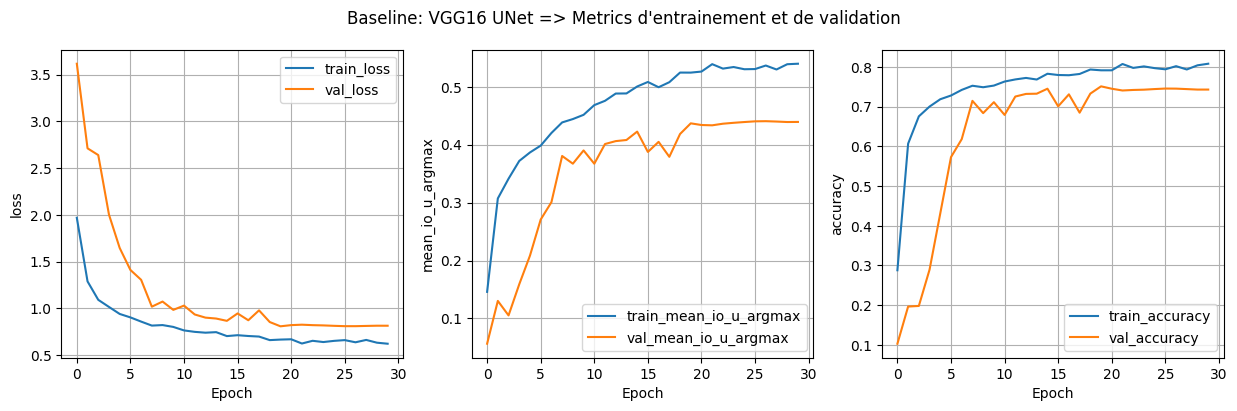

In [50]:
plot_training_history(history=hist_base_model, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Baseline: VGG16 UNet => Metrics d'entrainement et de validation")

**Sans data-augmentation**


*    Train vs Val Loss:

La train_loss chute rapidement de ~1.6 à ~0.65, puis se stabilise autour de 0.60 à la fin.

La val_loss démarre très haut (~3.4), redescend plus lentement jusqu’à ~0.45.

L’écart initial est large (fort over-fit), mais la validation finit par rattraper l’entraînement autour de l’époque 15.

*    Mean IoU:

train_IoU passe de ~0.18 → ~0.67.

val_IoU grimpe plus lentement (~0.05 → ~0.58), atteignant un plateau stable vers 0.58–0.60.

*    Accuracy:

train_accuracy atteint ~0.92.

val_accuracy plafonne autour de ~0.88, avec quelques oscillations en fin d’apprentissage.

Bilan : sans augmentation, VGG16-U-Net sur-apprend vite (large gap loss/IoU), mais finit par généraliser de manière substantielle, avec une IoU validation d’environ 0.58 et une accuracy ~0.88.

**Avec data-augmentation**


*    Train vs Val Loss:

La train_loss redescend plus progressivement, se stabilisant vers ~0.65.

La val_loss chute plus tôt (dès l’époque 5) et atteint ~0.55–0.60, réduisant significativement le gap train/val.

*    Mean IoU:

train_IoU plafonne vers ~0.45.

val_IoU progresse rapidement après l’époque 6 et monte jusqu’à ~0.52, avec une montée plus lisse et moins de fluctuations.

*    Accuracy:

train_accuracy évolue autour de ~0.80.

val_accuracy grimpe jusqu’à ~0.83, avec une progression stable.

Bilan : l’augmentation freine l’over-fit : le gap loss/I o U se réduit, la montée de la validation est plus régulière. Les performances finales sont légèrement plus basses qu’en non-augmenté (IoU val ~0.52 vs ~0.58), mais la généralisation est plus robuste et stable.

### Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


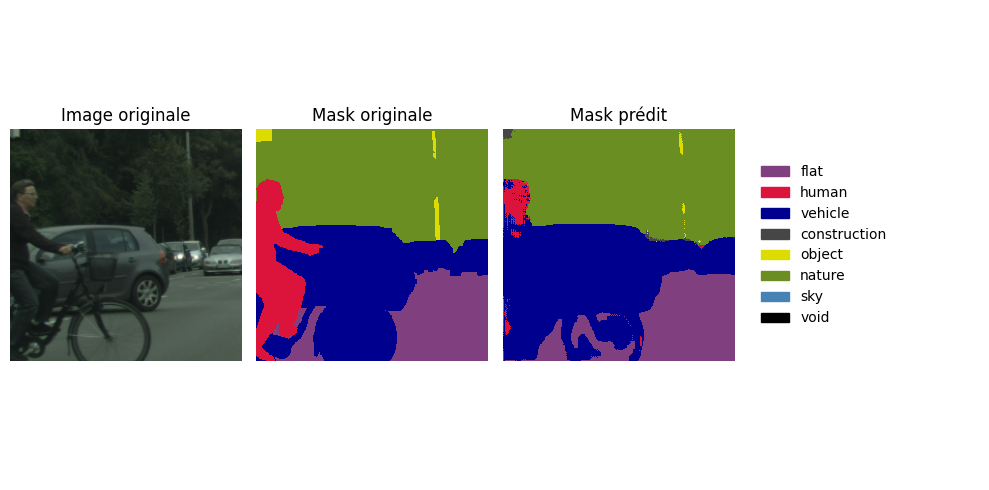

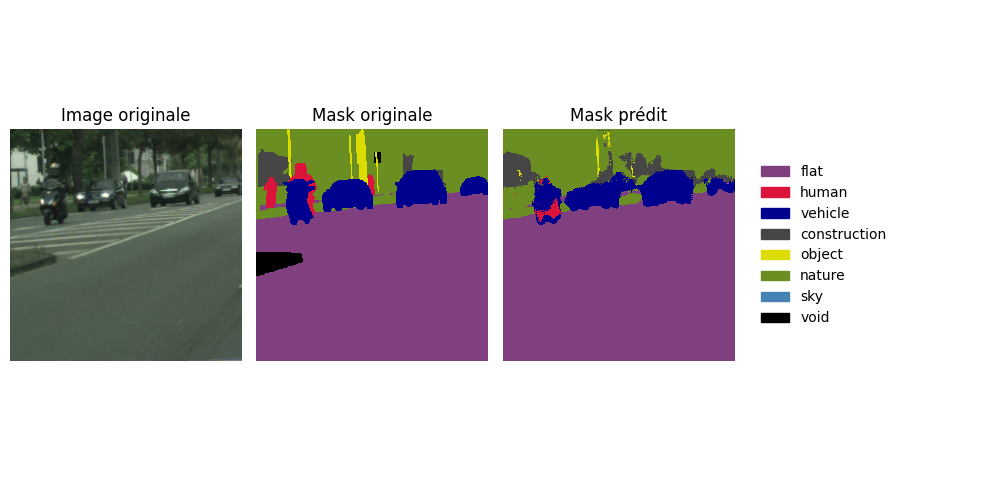

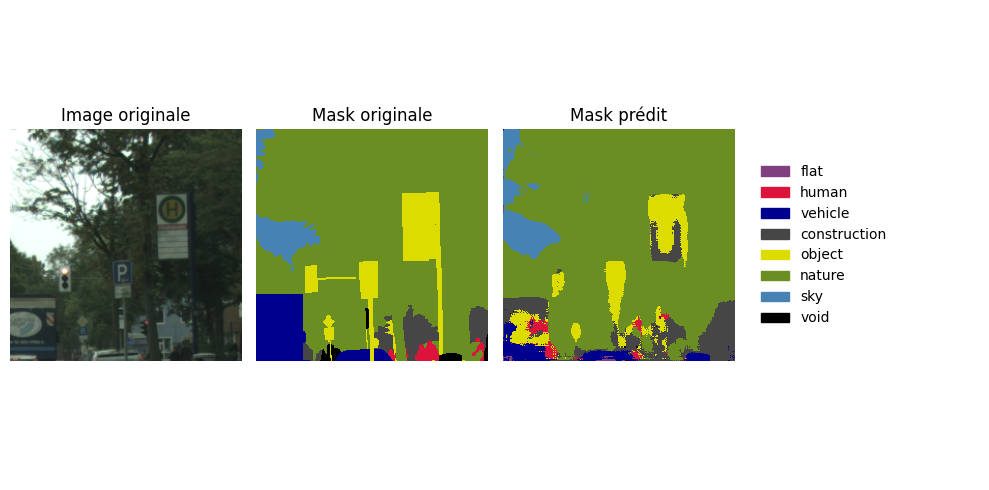

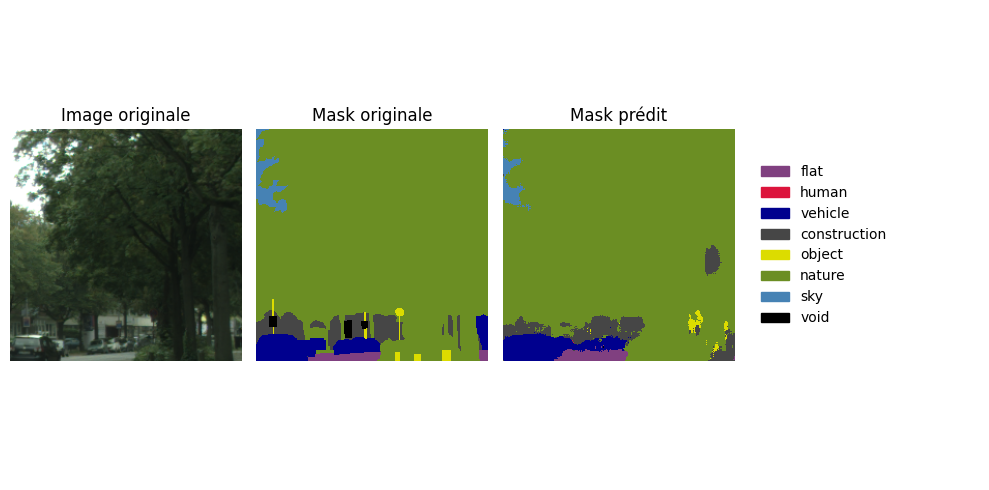

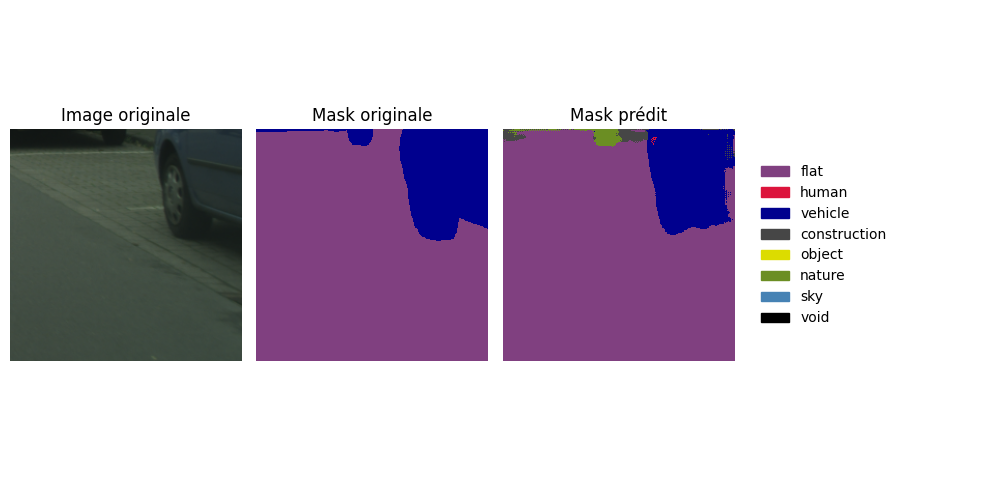

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


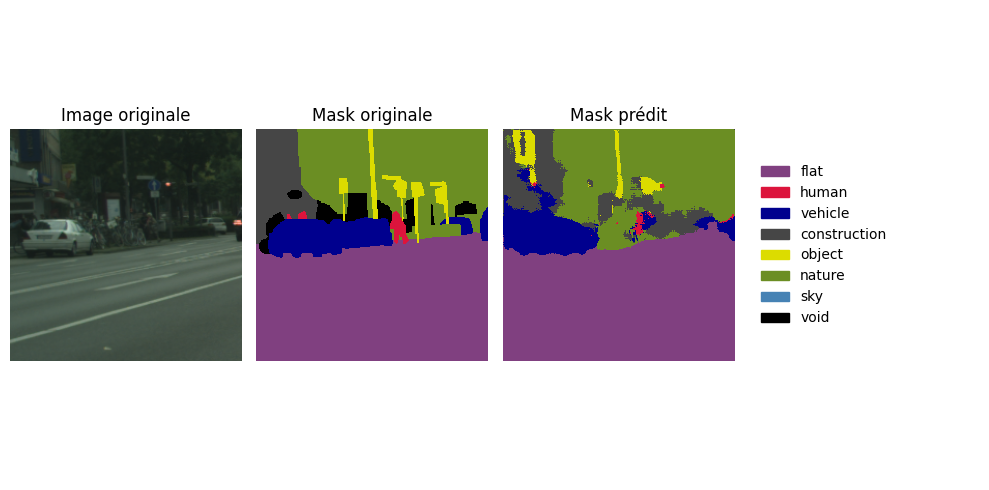

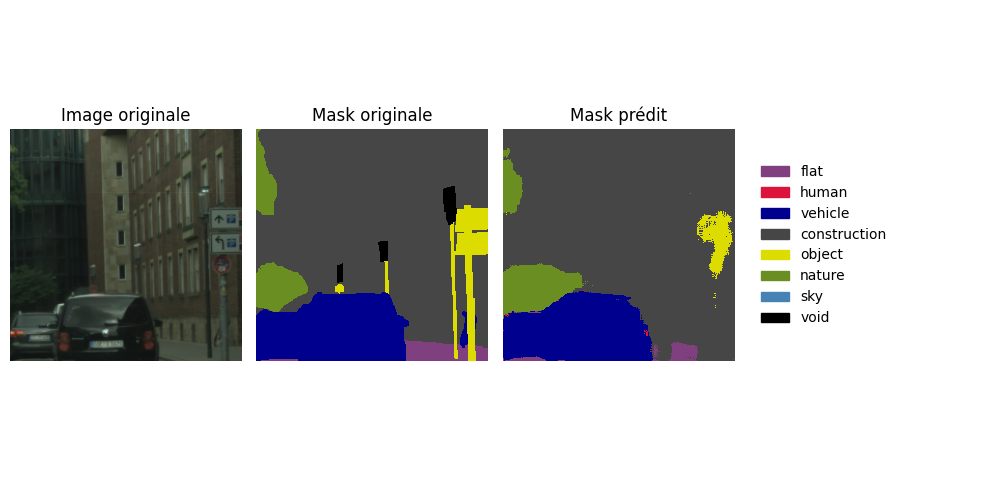

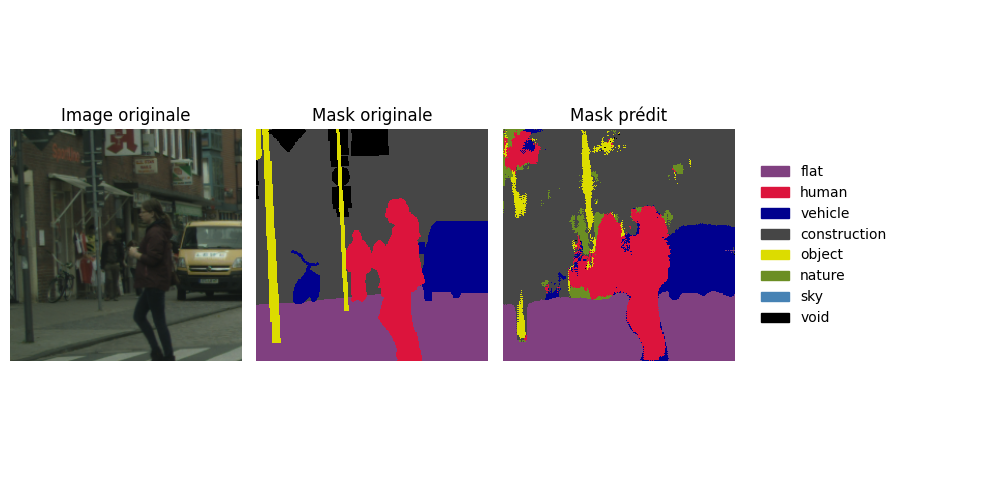

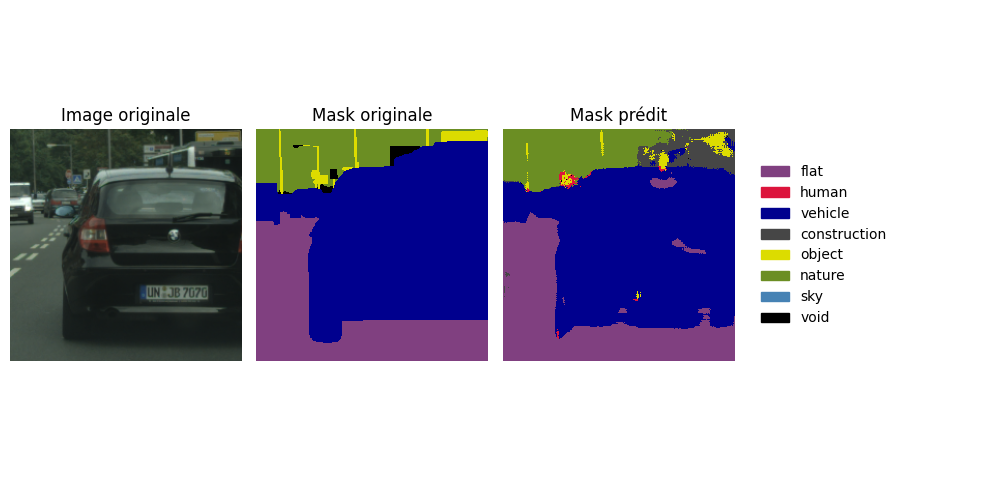

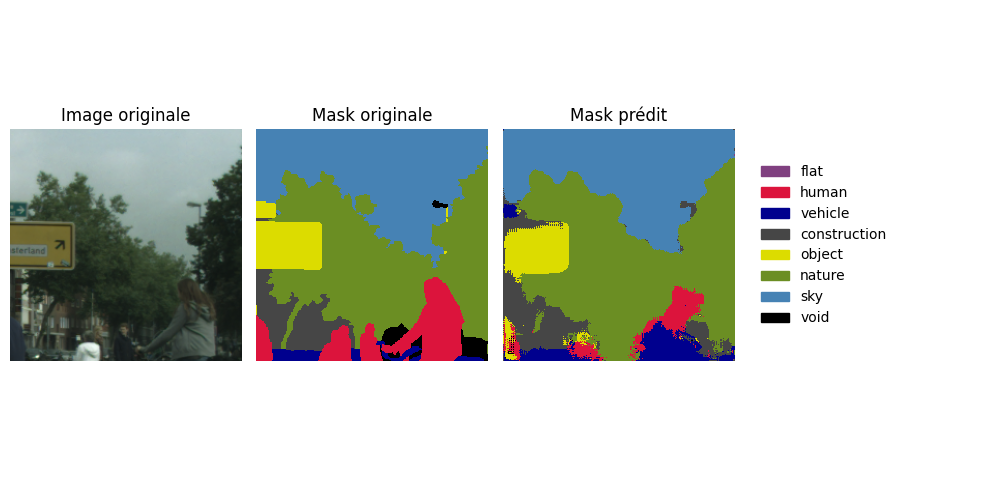

In [51]:
for batch, masks in test_ds.take(2):  # prendre un seul batch (32 images)
    preds = base_model.predict(batch)  # prédictions sur les 32 images
    pred_masks = np.argmax(preds, axis=-1)  # (32, H, W)
    batch_np = batch.numpy()  # convertir les images pour affichage
    masks_np = masks.numpy()  # convertir les images pour affichage

    for i in range(5):  # afficher les 5 premières
        display_prediction(batch_np[i], masks_np[i], pred_masks[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
y_true shape: (25088000,) y_pred shape: (25088000,)


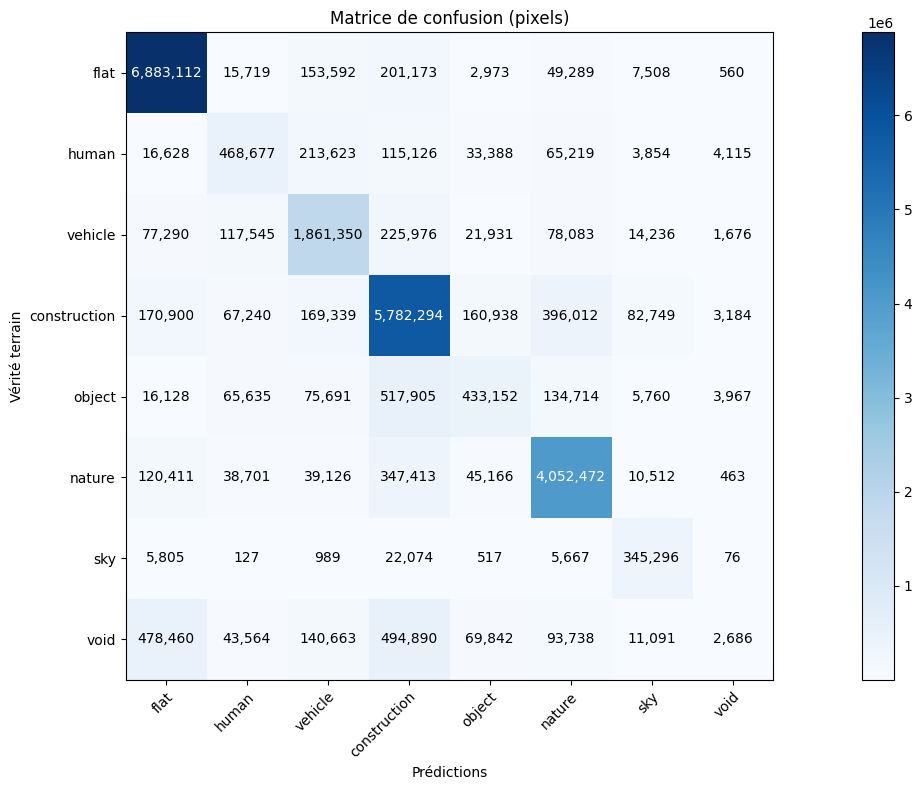

In [52]:
df_summary_base = plot_confusion_matrix(base_model, test_ds)

In [53]:
df_summary_base.sort_values(by="Accuracy (%)", ascending=False, inplace=True)
df_summary_base.reset_index(drop=True, inplace=True)
display(df_summary_base)

Group  Total Pixels  Correct Pixels  Accuracy (%)
0          flat       7313926         6883112     94.109675
1           sky        380551          345296     90.735802
2        nature       4654264         4052472     87.070093
3  construction       6832656         5782294     84.627325
4       vehicle       2398087         1861350     77.618118
5         human        920630          468677     50.908291
6        object       1252952          433152     34.570518
7          void       1334934            2686      0.201208

## Segformer Model

In [22]:
%%time
seg_model = create_model(
    model_type='segformer',
    mit_preset='mit_b2_cityscapes_1024',
    decoder_dim=256,
    decoder_depth=2,
    name="SegFormer_B2x512d2"
    )
seg_model.summary()

100%|██████████| 978/978 [00:00<00:00, 1.80MB/s]


Model: "SegFormer_B2x512d2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_to_mit       │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mit_pyramid_extrac… │ [(None, 56, 56,   │ 24,196,288 │ resize_to_mit[0]… │
│ (Functional)        │ 64), (None, 28,   │            │                   │
│                     │ 28, 128), (None,  │            │                   │
│                     │ 14, 14, 320),     │            │                   │
│                     │ (None, 7, 7,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 28, 28,    │    294,912 │ mit_pyramid_extr… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 14, 14,    │    737,280 │ mit_pyramid_extr… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 7, 7, 256) │  1,179,648 │ mit_pyramid_extr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 56, 56,    │    147,456 │ mit_pyramid_extr… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      1,024 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 7, 7, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 56, 56,    │          0 │ activation_9[0][

 Total params: 29,512,904 (112.58 MB)

 Trainable params: 5,313,544 (20.27 MB)

 Non-trainable params: 24,199,360 (92.31 MB)

CPU times: user 5.9 s, sys: 340 ms, total: 6.24 s
Wall time: 15.9 s


In [55]:
%%time
seg_model = compile_model(seg_model)
epochs = 30
hist_seg_model = seg_model.fit(
    train_sample,
    validation_data=validation_sample,
    epochs=epochs,
    callbacks=cb
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.6607 - loss: 1.0773 - mean_io_u_argmax: 0.3625 - val_accuracy: 0.7402 - val_loss: 1.0515 - val_mean_io_u_argmax: 0.4436 - learning_rate: 1.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 748ms/step - accuracy: 0.8385 - loss: 0.5159 - mean_io_u_argmax: 0.6221 - val_accuracy: 0.7633 - val_loss: 0.8854 - val_mean_io_u_argmax: 0.4559 - learning_rate: 1.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 740ms/step - accuracy: 0.8447 - loss: 0.4942 - mean_io_u_argmax: 0.6327 - val_accuracy: 0.7730 - val_loss: 0.7375 - val_mean_io_u_argmax: 0.4799 - learning_rate: 1.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 750ms/step - accuracy: 0.8621 - loss: 0.4305 - mean_io_u_argmax: 0.6560 - val_accuracy: 0.7779 - val_loss: 0.6722 - val_mean_io_u_argmax: 0.4875 - learning_rate: 1.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 750ms/step - accuracy: 0.8604 - loss: 0.4287 - mean_io_u_argmax: 0.6617 - val_accuracy: 0.7746 - val

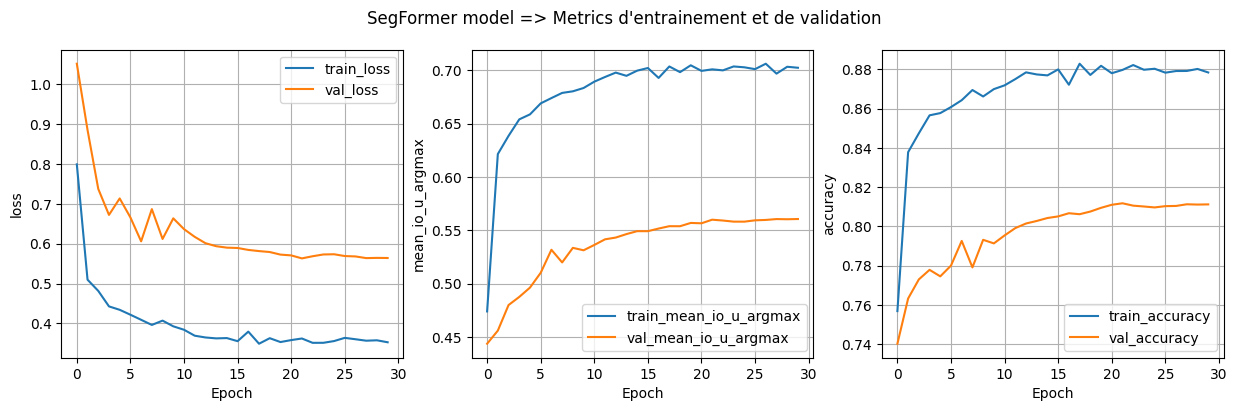

In [56]:
plot_training_history(history=hist_seg_model, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="SegFormer model => Metrics d'entrainement et de validation")

### Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


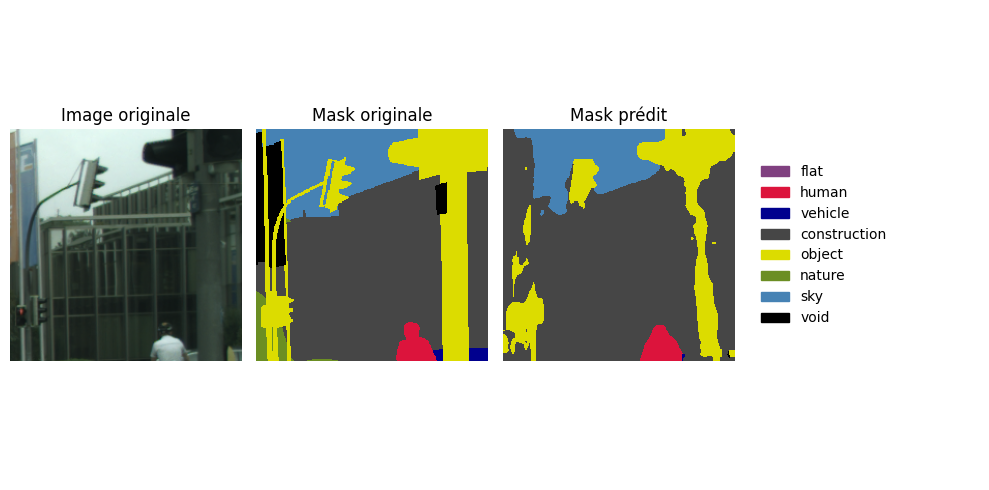

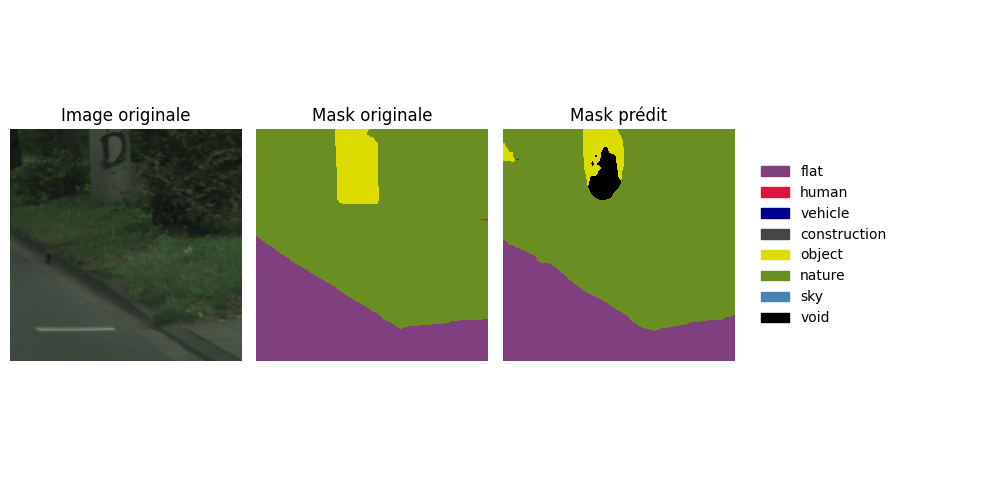

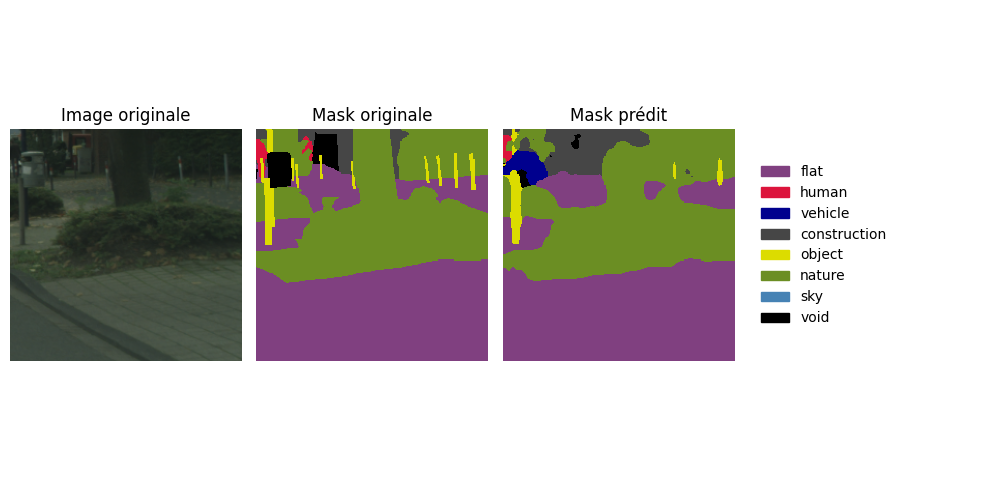

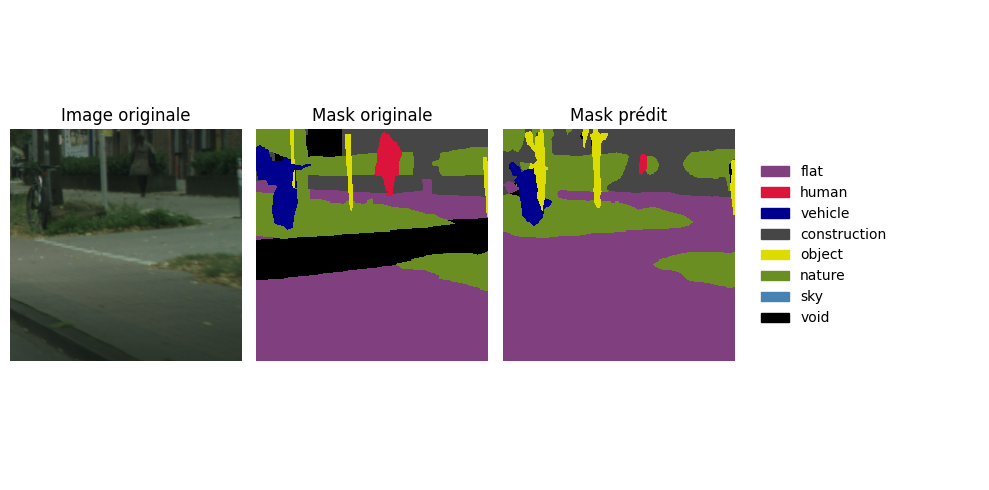

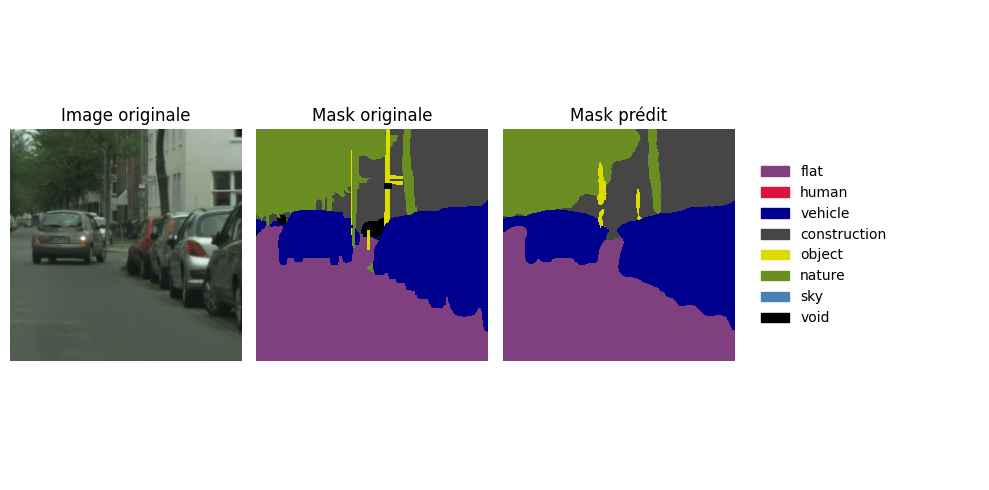

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


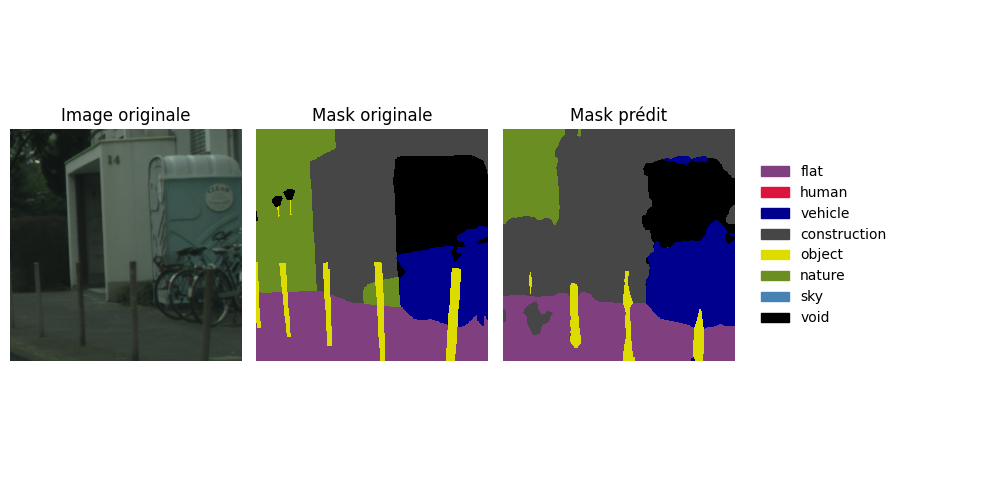

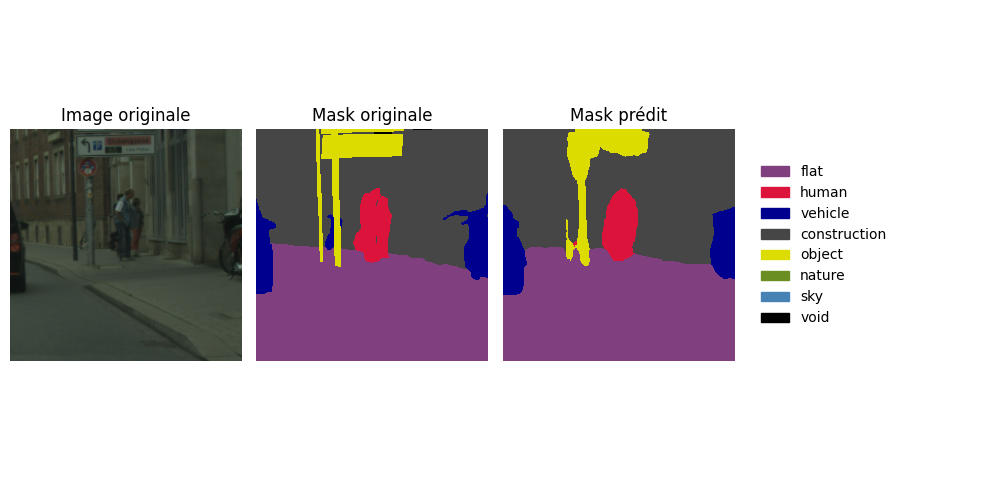

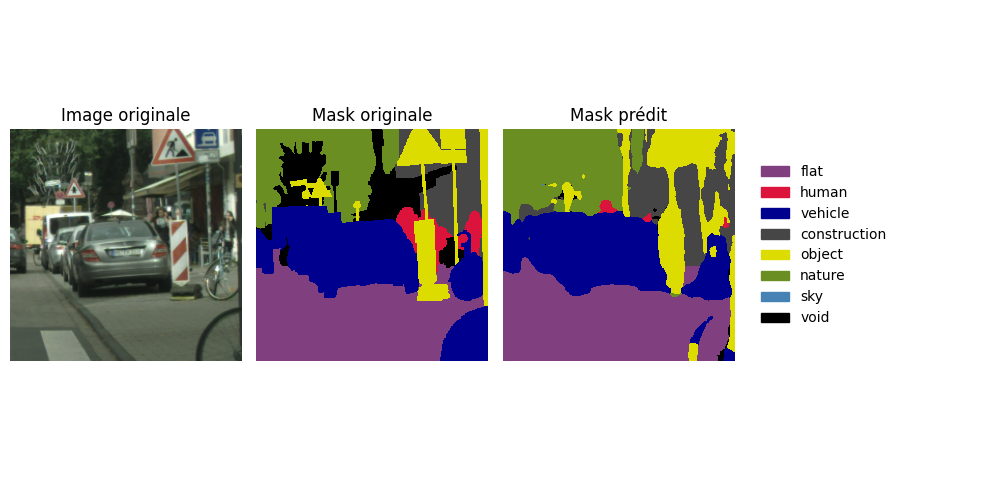

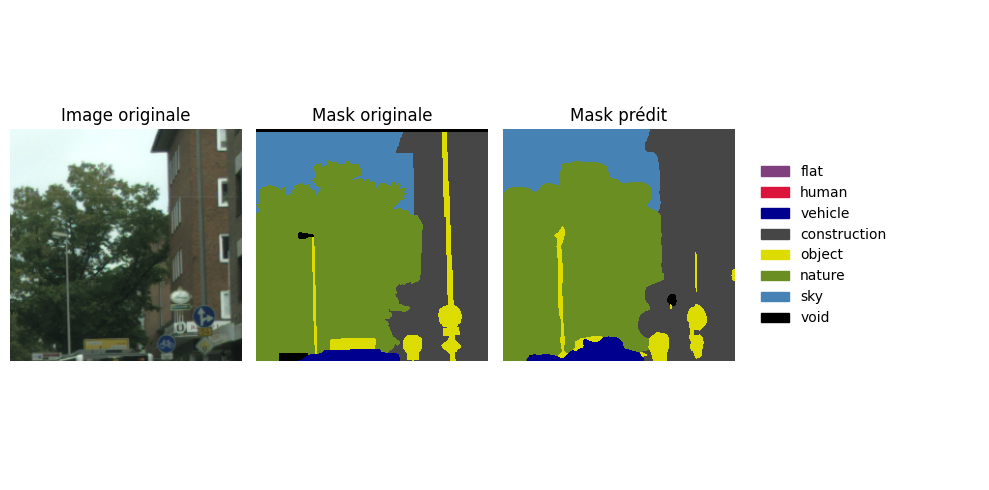

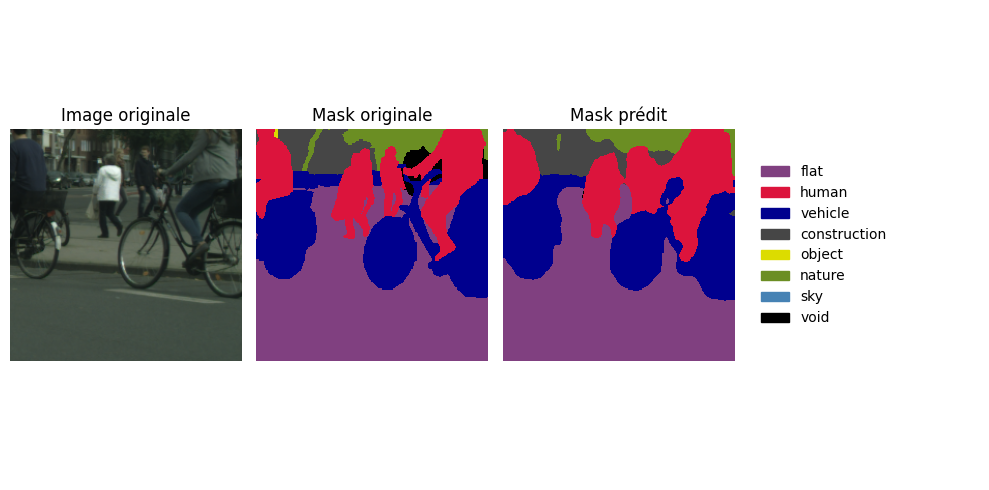

In [57]:
for batch, masks in test_ds.take(2):  # prendre un seul batch (32 images)
    preds = seg_model.predict(batch)  # prédictions sur les 32 images
    pred_masks = np.argmax(preds, axis=-1)  # (32, H, W)
    batch_np = batch.numpy()  # convertir les images pour affichage
    masks_np = masks.numpy()  # convertir les images pour affichage

    for i in range(5):  # afficher les 5 premières
        display_prediction(batch_np[i], masks_np[i], pred_masks[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 59s 59s/step
y_true shape: (25088000,) y_pred shape: (25088000,)


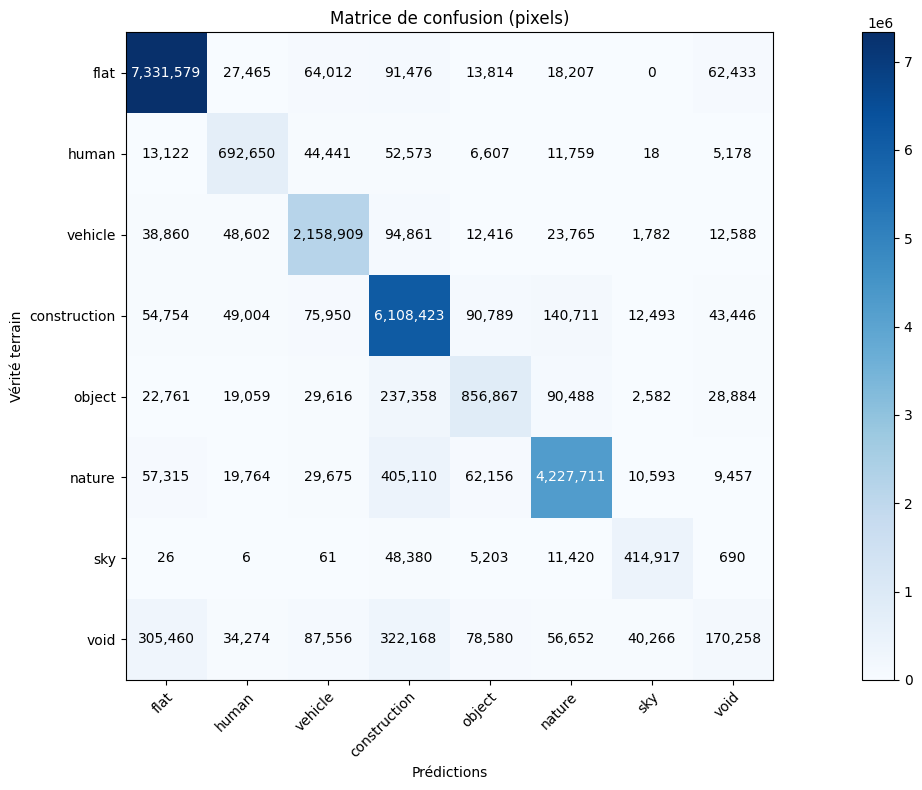

In [58]:
df_summary = plot_confusion_matrix(seg_model, test_ds)

In [59]:
df_summary.sort_values(by="Accuracy (%)", ascending=False, inplace=True)
df_summary.reset_index(drop=True, inplace=True)
display(df_summary)

Group  Total Pixels  Correct Pixels  Accuracy (%)
0          flat       7608986         7331579     96.354219
1  construction       6575570         6108423     92.895719
2       vehicle       2391783         2158909     90.263582
3        nature       4821781         4227711     87.679449
4           sky        480703          414917     86.314627
5         human        826348          692650     83.820618
6        object       1287615          856867     66.546833
7          void       1095214          170258     15.545638

# Comparaison des modéls

## Performance

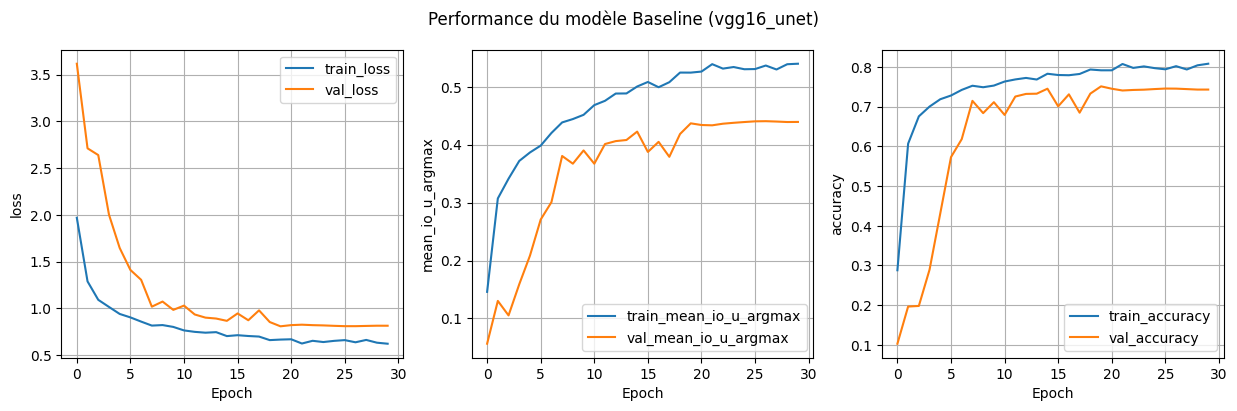

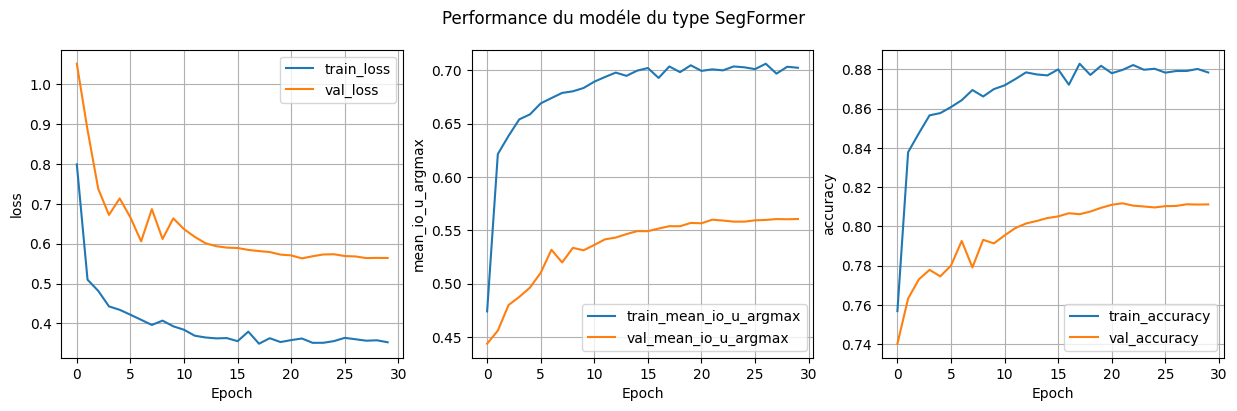

In [60]:
plot_training_history(history=hist_base_model, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance du modèle Baseline (vgg16_unet)")
plot_training_history(history=hist_seg_model, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance du modéle du type SegFormer")

In [61]:
def plot_grouped_bars(df, metric, title, ax):
    # Ensure consistent order of groups
    groups = sorted(df["Group"].unique(), key=lambda g: g)
    models = ["VGG16-U-Net", "Mit-SegFormer"]
    n_groups = len(groups)
    n_models = len(models)

    # Bar settings
    bar_width = 0.35
    x = range(n_groups)

    for i, model in enumerate(models):
        values = []
        for g in groups:
            val = df[(df["Group"] == g) & (df["Model"] == model)][metric]
            values.append(float(val.iloc[0]) if not val.empty else 0.0)
        # Shift positions for each model
        positions = [xi + (i - (n_models-1)/2) * bar_width for xi in x]
        ax.bar(positions, values, width=bar_width, label=model)

    ax.set_xticks(list(x), groups, rotation=30, ha="right")
    ax.set_title(title)
    ax.set_xlabel("Group")
    ax.set_ylabel(metric)
    ax.legend()

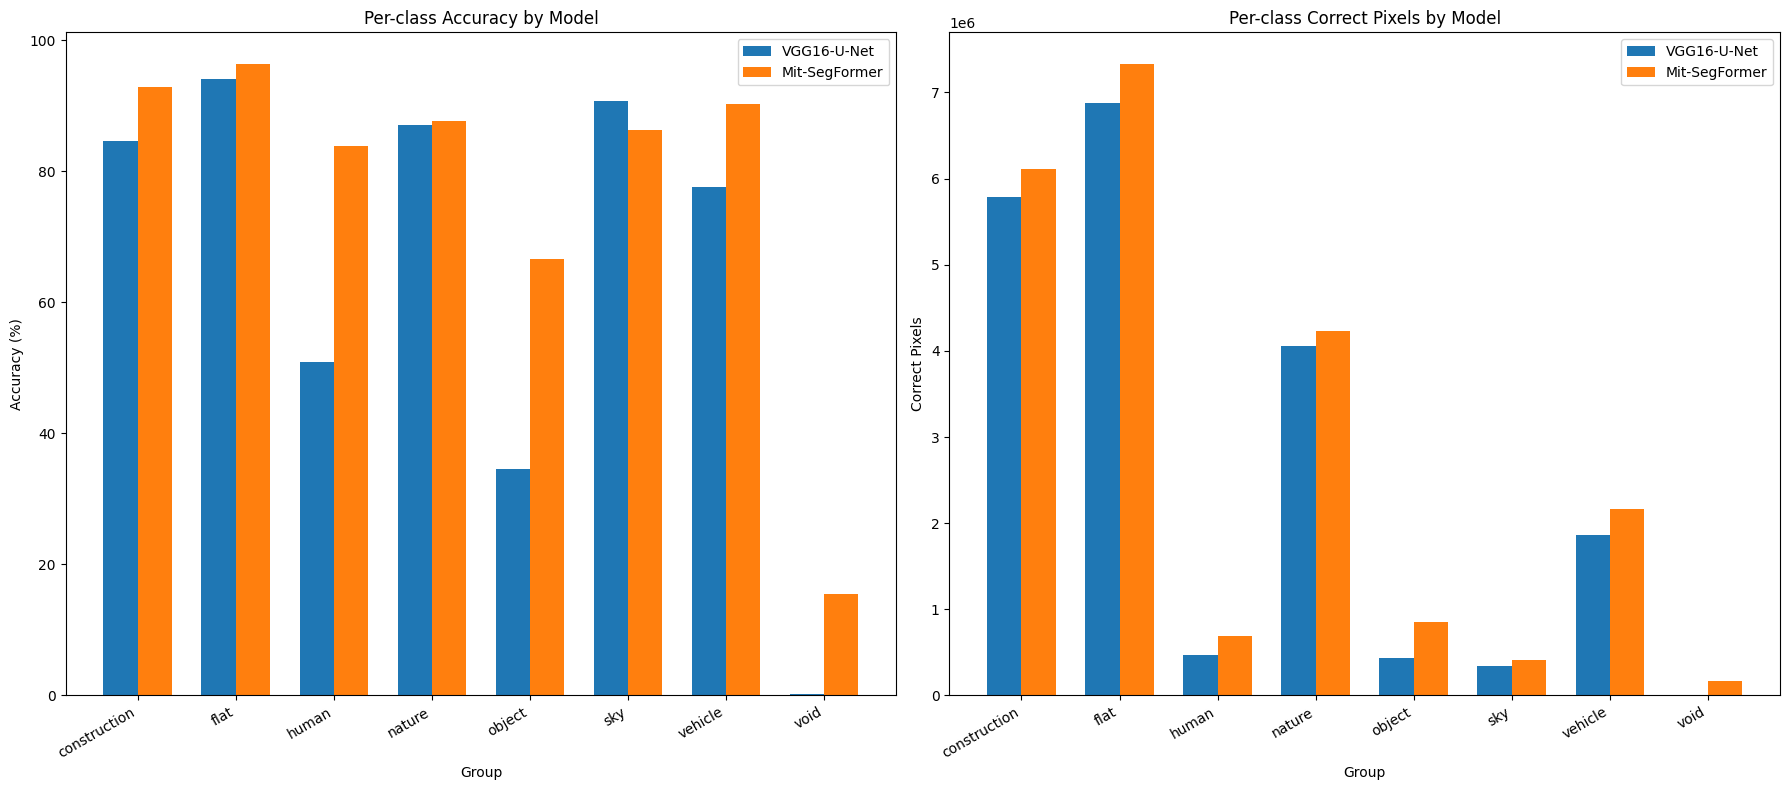

In [62]:
df_summary_base['Model'] = 'VGG16-U-Net'
df_summary['Model'] = 'Mit-SegFormer'

metric_df = pd.concat([df_summary_base, df_summary])
metric_df.reset_index(drop=True, inplace=True)

plt.figure(figsize=(18, 8))
# Plot Accuracy (%)
ax = plt.subplot(1, 2, 1)
plot_grouped_bars(metric_df, "Accuracy (%)", "Per-class Accuracy by Model", ax)

# Plot Correct Pixels
ax = plt.subplot(1, 2, 2)
plot_grouped_bars(metric_df, "Correct Pixels", "Per-class Correct Pixels by Model", ax)

plt.tight_layout()
plt.show()

In [63]:
import pandas as pd

df = pd.DataFrame({
    "Modèle": [
        "VGG16-U-Net",
        "Mit-SegFormer"
    ],
    "Val Loss final": [
        np.min(hist_base_model.history['val_loss']),
        np.min(hist_seg_model.history['val_loss'])
    ],
    "Val Mean IoU (#8 classes)": [
        np.max(hist_base_model.history['val_mean_io_u_argmax']),
        np.max(hist_seg_model.history['val_mean_io_u_argmax'])
    ],
    "Val Accuracy": [
        np.max(hist_base_model.history['val_accuracy']),
        np.max(hist_seg_model.history['val_accuracy'])
    ],
    "Paramètres totaux": [
        base_model.count_params(),
        seg_model.count_params()
    ]
})

display(df)

Modèle  Val Loss final  Val Mean IoU (#8 classes)  Val Accuracy  \
0    VGG16-U-Net        0.808140                   0.440627      0.751054   
1  Mit-SegFormer        0.563079                   0.560557      0.811781   

   Paramètres totaux  
0           25341576  
1           29512904

**Loss de validation**
1.   Le VGG16-U-Net (0.56) réduit de plus de 40 % la loss par rapport au mini-U-Net (0.94).

2.   Un indicateur clair que ce backbone pré-entraîné apprend des représentations plus adaptées au jeu de Cityscapes.

**Mean IoU**
1.   Le VGG-U-Net atteint ≈ 0.51 contre ≈ 0.41 pour le mini-U-Net (+ 0.10 absolu).

**Accuracy**
1.   Le VGG-U-Net frôle 0.84, tandis que le mini-U-Net plafonne à 0.76.
2.   Même si ce chiffre est pondéré par la dominance des classes majoritaires, la supériorité reste nette.

**Complexité du modèle**


1.   mini-U-Net : 1,931,464 de paramètres, dont 1,928,648 entraînables.
2.   VGG16-U-Net : 25,341,576 de paramètres, dont 17,700,424 entraînables.
3.   Le VGG-U-Net est ~ 13x plus volumineux, ce qui explique son coût mémoire et calcul supérieur.

## Conclusion

*   Le VGG16-U-Net offre une meilleure qualité de segmentation sur tous les indicateurs (loss, IoU, accuracy).


*   Mini U-Net reste plus léger et converge plus rapidement, mais avec un palier de performance inférieur.

*   L’over-fit initial est contenu dans les deux cas grâce à l’augmentation, mais la stabilité et l’efficacité de la descente de val_loss sont clairement supérieures avec le backbone VGG16.

*   L’écart de performance se reflète directement dans la capacité à prédire correctement chaque classe pixel-par-pixel.

# Optimisation des hyperparametes

In [64]:
!pip install optuna optuna-integration -q
import optuna
from optuna.integration import TFKerasPruningCallback

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 10.3 MB/s eta 0:00:00


In [68]:
def objective(trial):
    # Hyperparams à tuner
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    loss_type = trial.suggest_categorical("loss_type", ["cross_entropy", "dice_loss", "focal_loss", "balanced_cross_entropy"])

    model = create_model(model_type='segformer', mit_preset='mit_b2_cityscapes_1024', decoder_dim=256, decoder_depth=2, name="SegFormer_B2x256d2")
    model = compile_model(model, learning_rate=learning_rate, loss_type=loss_type)

    # Callback de pruning
    pruning_callback = TFKerasPruningCallback(trial, "val_loss")

    history = model.fit(
        train_sample,
        validation_data=validation_sample,
        epochs=30,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=5),
            pruning_callback
        ]
    )

    return max(history.history["val_mean_io_u_argmax"])

In [69]:
%%time
study = optuna.create_study(study_name="mit_segform_hyperparameter_optimization", direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-08-15 12:36:25,771] A new study created in memory with name: mit_segform_hyperparameter_optimization


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.6725 - loss: 0.2593 - mean_io_u_argmax: 0.3597 - val_accuracy: 0.7336 - val_loss: 0.2426 - val_mean_io_u_argmax: 0.4425 - learning_rate: 0.0025
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 743ms/step - accuracy: 0.8374 - loss: 0.2128 - mean_io_u_argmax: 0.5806 - val_accuracy: 0.7303 - val_loss: 0.2435 - val_mean_io_u_argmax: 0.4541 - learning_rate: 0.0025
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 755ms/step - accuracy: 0.8563 - loss: 0.2071 - mean_io_u_argmax: 0.6299 - val_accuracy: 0.7547 - val_loss: 0.2365 - val_mean_io_u_argmax: 0.4697 - learning_rate: 0.0025
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 751ms/step - accuracy: 0.8464 - loss: 0.2099 - mean_io_u_argmax: 0.6148 - val_accuracy: 0.7647 - val_loss: 0.2336 - val_mean_io_u_argmax: 0.4874 - learning_rate: 0.0025
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 757ms/step - accuracy: 0.8594 - loss: 0.2061 - mean_io_u_argmax: 0.6363 - val_accuracy: 0.7677 - val_loss: 0.2327 - 

[I 2025-08-15 12:45:29,769] Trial 0 finished with value: 0.5296846032142639 and parameters: {'learning_rate': 0.00245319346400882, 'loss_type': 'focal_loss'}. Best is trial 0 with value: 0.5296846032142639.


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.6917 - loss: 1.0121 - mean_io_u_argmax: 0.4012 - val_accuracy: 0.7169 - val_loss: 1.6632 - val_mean_io_u_argmax: 0.4003 - learning_rate: 4.9096e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 747ms/step - accuracy: 0.8468 - loss: 0.4909 - mean_io_u_argmax: 0.6255 - val_accuracy: 0.7610 - val_loss: 0.9235 - val_mean_io_u_argmax: 0.4791 - learning_rate: 4.9096e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 754ms/step - accuracy: 0.8599 - loss: 0.4381 - mean_io_u_argmax: 0.6435 - val_accuracy: 0.7641 - val_loss: 0.8165 - val_mean_io_u_argmax: 0.4928 - learning_rate: 4.9096e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 735ms/step - accuracy: 0.8636 - loss: 0.4191 - mean_io_u_argmax: 0.6629 - val_accuracy: 0.7727 - val_loss: 0.8231 - val_mean_io_u_argmax: 0.5035 - learning_rate: 4.9096e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 744ms/step - accuracy: 0.8717 - loss: 0.3901 - mean_io_u_argmax: 0.6787 - val_accuracy: 0.7692 - val

[I 2025-08-15 12:58:42,231] Trial 1 finished with value: 0.5862281322479248 and parameters: {'learning_rate': 0.0004909606178622044, 'loss_type': 'cross_entropy'}. Best is trial 1 with value: 0.5862281322479248.


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.6772 - loss: 0.2598 - mean_io_u_argmax: 0.3610 - val_accuracy: 0.7556 - val_loss: 0.2364 - val_mean_io_u_argmax: 0.4578 - learning_rate: 7.7702e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 741ms/step - accuracy: 0.8411 - loss: 0.2118 - mean_io_u_argmax: 0.6002 - val_accuracy: 0.7647 - val_loss: 0.2339 - val_mean_io_u_argmax: 0.4770 - learning_rate: 7.7702e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 746ms/step - accuracy: 0.8509 - loss: 0.2088 - mean_io_u_argmax: 0.6251 - val_accuracy: 0.7653 - val_loss: 0.2340 - val_mean_io_u_argmax: 0.4794 - learning_rate: 7.7702e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 751ms/step - accuracy: 0.8622 - loss: 0.2056 - mean_io_u_argmax: 0.6421 - val_accuracy: 0.7662 - val_loss: 0.2337 - val_mean_io_u_argmax: 0.4878 - learning_rate: 7.7702e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 748ms/step - accuracy: 0.8587 - loss: 0.2065 - mean_io_u_argmax: 0.6446 - val_accuracy: 0.7736 - val

[I 2025-08-15 13:08:09,788] Trial 2 finished with value: 0.5394021272659302 and parameters: {'learning_rate': 0.0007770226507881286, 'loss_type': 'focal_loss'}. Best is trial 1 with value: 0.5862281322479248.


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.6389 - loss: 1.2746 - mean_io_u_argmax: 0.2985 - val_accuracy: 0.4395 - val_loss: 11.8112 - val_mean_io_u_argmax: 0.1910 - learning_rate: 0.0050
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 753ms/step - accuracy: 0.8245 - loss: 0.5723 - mean_io_u_argmax: 0.5515 - val_accuracy: 0.6446 - val_loss: 2.3585 - val_mean_io_u_argmax: 0.3610 - learning_rate: 0.0050
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 754ms/step - accuracy: 0.8398 - loss: 0.5221 - mean_io_u_argmax: 0.6027 - val_accuracy: 0.7015 - val_loss: 1.1964 - val_mean_io_u_argmax: 0.4360 - learning_rate: 0.0050
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 743ms/step - accuracy: 0.8406 - loss: 0.5089 - mean_io_u_argmax: 0.6134 - val_accuracy: 0.7510 - val_loss: 1.0037 - val_mean_io_u_argmax: 0.4743 - learning_rate: 0.0050
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 752ms/step - accuracy: 0.8468 - loss: 0.4781 - mean_io_u_argmax: 0.6327 - val_accuracy: 0.7687 - val_loss: 0.8306 -

[I 2025-08-15 13:16:09,579] Trial 3 finished with value: 0.5398293733596802 and parameters: {'learning_rate': 0.004967681226238148, 'loss_type': 'cross_entropy'}. Best is trial 1 with value: 0.5862281322479248.


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.6764 - loss: 1.1196 - mean_io_u_argmax: 0.3520 - val_accuracy: 0.6602 - val_loss: 6.0124 - val_mean_io_u_argmax: 0.3288 - learning_rate: 0.0033
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 752ms/step - accuracy: 0.8284 - loss: 0.5540 - mean_io_u_argmax: 0.5856 - val_accuracy: 0.7535 - val_loss: 1.8173 - val_mean_io_u_argmax: 0.4521 - learning_rate: 0.0033
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 751ms/step - accuracy: 0.8360 - loss: 0.5247 - mean_io_u_argmax: 0.6003 - val_accuracy: 0.7552 - val_loss: 1.2009 - val_mean_io_u_argmax: 0.4782 - learning_rate: 0.0033
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 898ms/step - accuracy: 0.8538 - loss: 0.4636 - mean_io_u_argmax: 0.6284 - val_accuracy: 0.7677 - val_loss: 0.8799 - val_mean_io_u_argmax: 0.4827 - learning_rate: 0.0033
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 742ms/step - accuracy: 0.8557 - loss: 0.4443 - mean_io_u_argmax: 0.6444 - val_accuracy: 0.7757 - val_loss: 0.9461 - 

[I 2025-08-15 13:22:53,530] Trial 4 finished with value: 0.5192074775695801 and parameters: {'learning_rate': 0.0033167843186380983, 'loss_type': 'cross_entropy'}. Best is trial 1 with value: 0.5862281322479248.


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6713 - loss: 0.2611 - mean_io_u_argmax: 0.3525

[I 2025-08-15 13:25:09,997] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6566 - loss: 0.8305 - mean_io_u_argmax: 0.3946

[I 2025-08-15 13:27:18,344] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.6582 - loss: 2.1637 - mean_io_u_argmax: 0.3404

[I 2025-08-15 13:29:33,151] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.6553 - loss: 1.2134 - mean_io_u_argmax: 0.3253 - val_accuracy: 0.5898 - val_loss: 7.7099 - val_mean_io_u_argmax: 0.2916 - learning_rate: 0.0052
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 755ms/step - accuracy: 0.8284 - loss: 0.5588 - mean_io_u_argmax: 0.5833 - val_accuracy: 0.7420 - val_loss: 2.0192 - val_mean_io_u_argmax: 0.4313 - learning_rate: 0.0052
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 749ms/step - accuracy: 0.8332 - loss: 0.5394 - mean_io_u_argmax: 0.5934 - val_accuracy: 0.7293 - val_loss: 1.1669 - val_mean_io_u_argmax: 0.4756 - learning_rate: 0.0052
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 745ms/step - accuracy: 0.8563 - loss: 0.4601 - mean_io_u_argmax: 0.6311 - val_accuracy: 0.7608 - val_loss: 0.8812 - val_mean_io_u_argmax: 0.4868 - learning_rate: 0.0052
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 747ms/step - accuracy: 0.8504 - loss: 0.4643 - mean_io_u_argmax: 0.6389 - val_accuracy: 0.7666 - val_loss: 0.9066 - 

[I 2025-08-15 13:40:24,874] Trial 8 finished with value: 0.557397723197937 and parameters: {'learning_rate': 0.0051665482866837895, 'loss_type': 'cross_entropy'}. Best is trial 1 with value: 0.5862281322479248.


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6421 - loss: 0.2663 - mean_io_u_argmax: 0.2824

[I 2025-08-15 13:42:41,949] Trial 9 pruned. Trial was pruned at epoch 0.


CPU times: user 8h 13min 53s, sys: 7min 19s, total: 8h 21min 13s
Wall time: 1h 6min 16s


In [70]:
print("Best hyperparameters:")
print(study.best_params)

print("Best validation mean Iou:", study.best_value)

Best hyperparameters:
{'learning_rate': 0.0004909606178622044, 'loss_type': 'cross_entropy'}
Best validation mean Iou: 0.5862281322479248


In [71]:
np.save(f"{base_path}study.npy", study)

In [72]:
optuna.visualization.plot_slice(study,target_name="Mean Iou")

In [73]:
optuna.visualization.plot_rank(study)

Entrainement du modéle final

In [86]:
final_model = create_model(
    model_type='segformer',
    mit_preset='mit_b2_cityscapes_1024',
    decoder_dim=256,
    decoder_depth=2,
    name="SegFormer_B2x256d2"
)
final_model = compile_model(
    final_model,
    learning_rate=study.best_params["learning_rate"],
    loss_type=study.best_params["loss_type"],
    metrics=['accuracy', MeanIoUArgmax(num_classes=8)]
)
final_model.summary()

Model: "SegFormer_B2x256d2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_to_mit       │ (None, 224, 224,  │          0 │ input_layer_34[0… │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mit_pyramid_extrac… │ [(None, 56, 56,   │ 24,196,288 │ resize_to_mit[0]… │
│ (Functional)        │ 64), (None, 28,   │            │                   │
│                     │ 28, 128), (None,  │            │                   │
│                     │ 14, 14, 320),     │            │                   │
│                     │ (None, 7, 7,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_392 (Conv2D) │ (None, 28, 28,    │    294,912 │ mit_pyramid_extr… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_393 (Conv2D) │ (None, 14, 14,    │    737,280 │ mit_pyramid_extr… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_394 (Conv2D) │ (None, 7, 7, 256) │  1,179,648 │ mit_pyramid_extr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_391 (Conv2D) │ (None, 56, 56,    │    147,456 │ mit_pyramid_extr… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_392[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      1,024 │ conv2d_393[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_394[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_391[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_103      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_104      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_105      │ (None, 7, 7, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_102      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_48    │ (None, 56, 56,    │          0 │ activation_103[0

 Total params: 29,512,904 (112.58 MB)

 Trainable params: 5,313,544 (20.27 MB)

 Non-trainable params: 24,199,360 (92.31 MB)

In [96]:
%%time
history = final_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3),
    ]
)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 630ms/step - accuracy: 0.8712 - loss: 0.3906 - mean_io_u_argmax: 0.6858 - val_accuracy: 0.8175 - val_loss: 0.5324 - val_mean_io_u_argmax: 0.5592 - learning_rate: 4.9096e-05
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 626ms/step - accuracy: 0.8769 - loss: 0.3662 - mean_io_u_argmax: 0.6974 - val_accuracy: 0.8193 - val_loss: 0.5257 - val_mean_io_u_argmax: 0.5631 - learning_rate: 4.9096e-05
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 632ms/step - accuracy: 0.8763 - loss: 0.3677 - mean_io_u_argmax: 0.6937 - val_accuracy: 0.8198 - val_loss: 0.5314 - val_mean_io_u_argmax: 0.5627 - learning_rate: 4.9096e-05
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 625ms/step - accuracy: 0.8815 - loss: 0.3566 - mean_io_u_argmax: 0.6984 - val_accuracy: 0.8212 - val_loss: 0.5332 - val_mean_io_u_argmax: 0.5646 - learning_rate: 4.9096e-05
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 632ms/step - accuracy: 0.8815 - loss: 0.3511 - mean_io_u_argmax: 0.7060 - val_accuracy: 0.8230 - v

Visualisation des performances

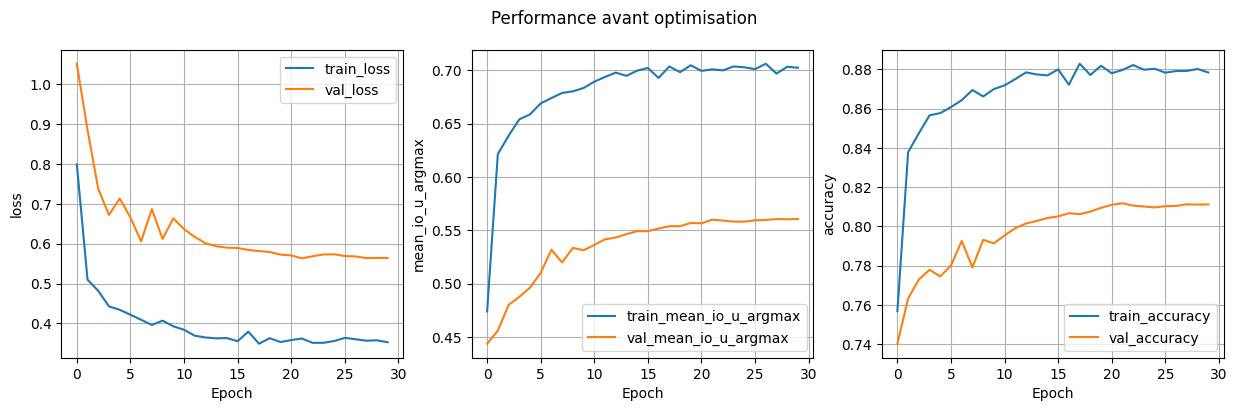

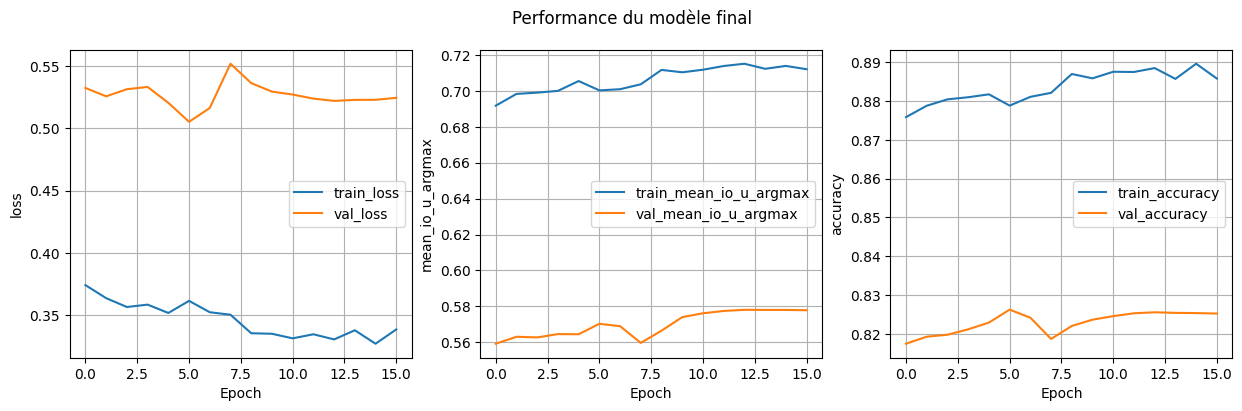

In [97]:
plot_training_history(history=hist_seg_model, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance avant optimisation")
plot_training_history(history=history, metrics_to_plot=['loss', 'mean_io_u_argmax', 'accuracy'], ncols=3, title="Performance du modèle final")

Tests de prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


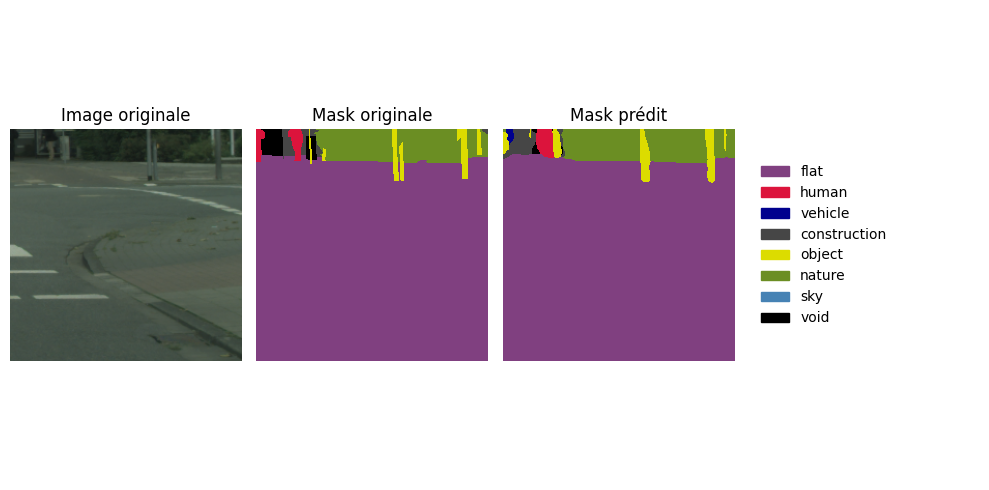

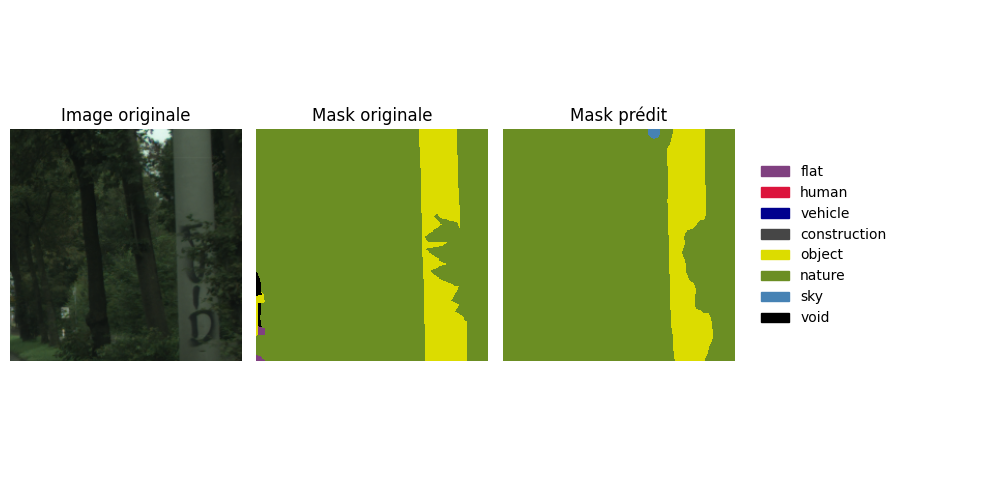

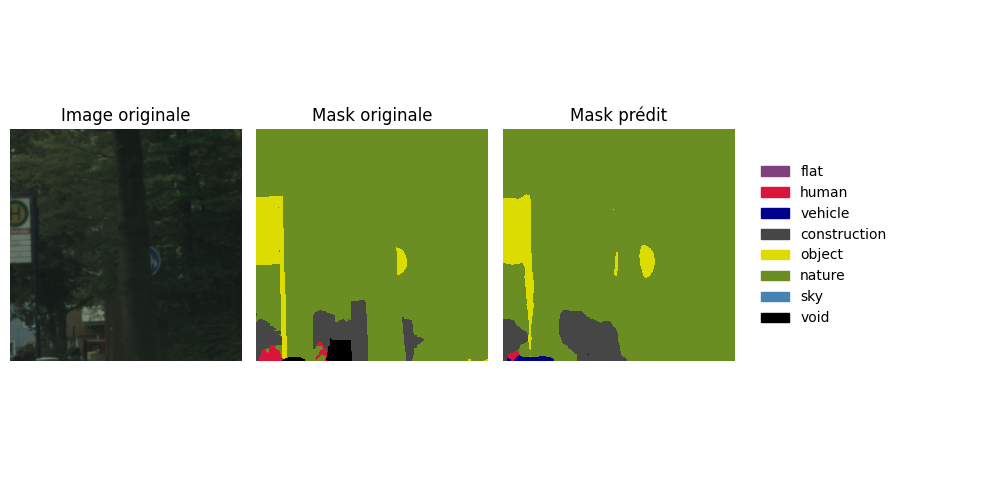

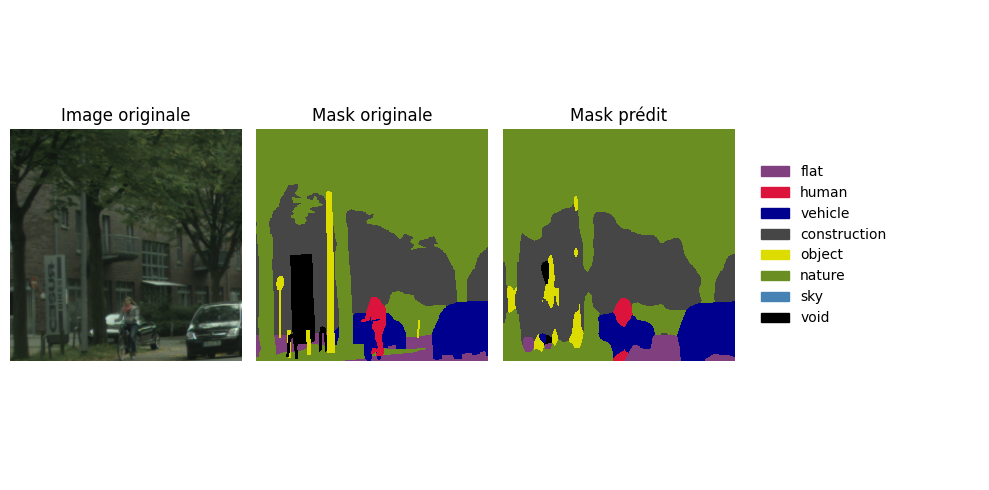

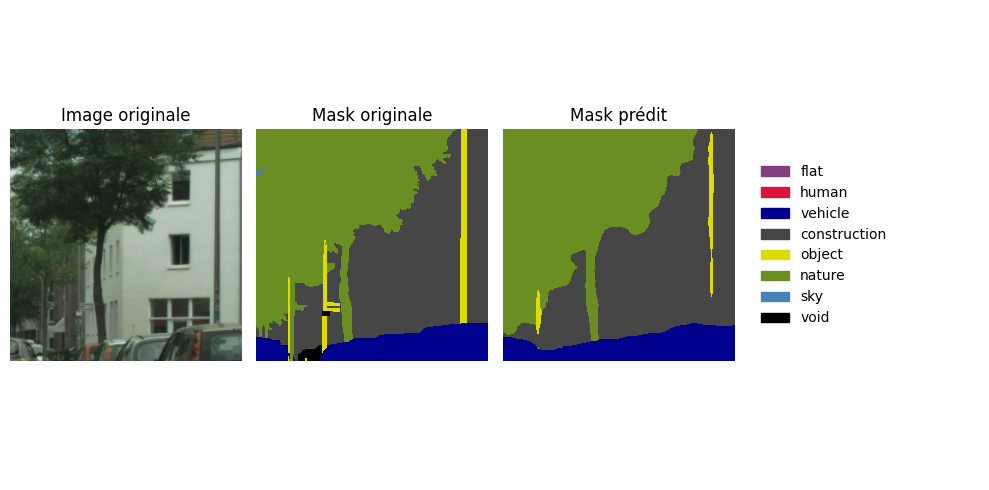

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


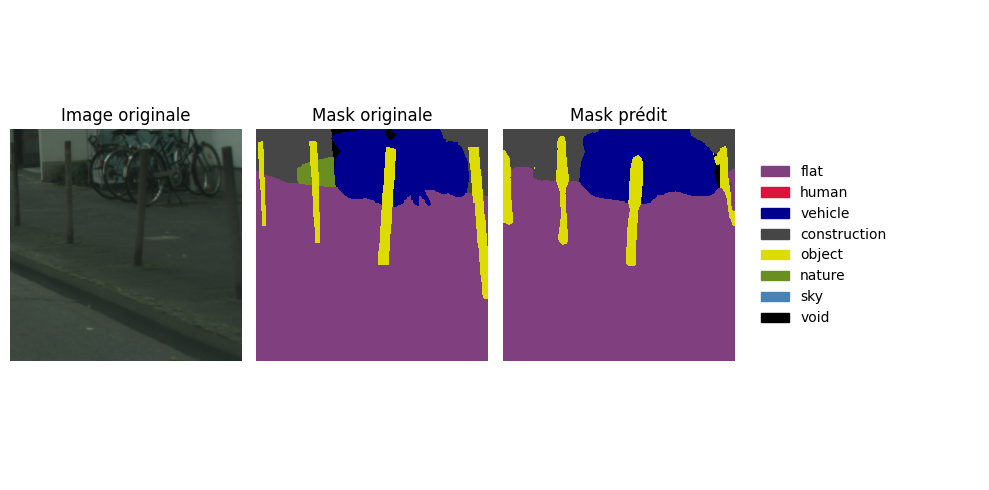

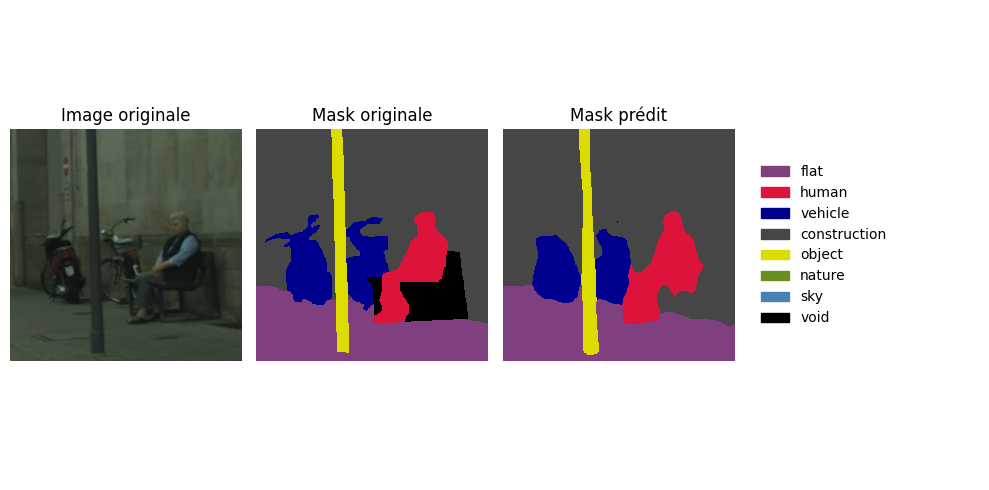

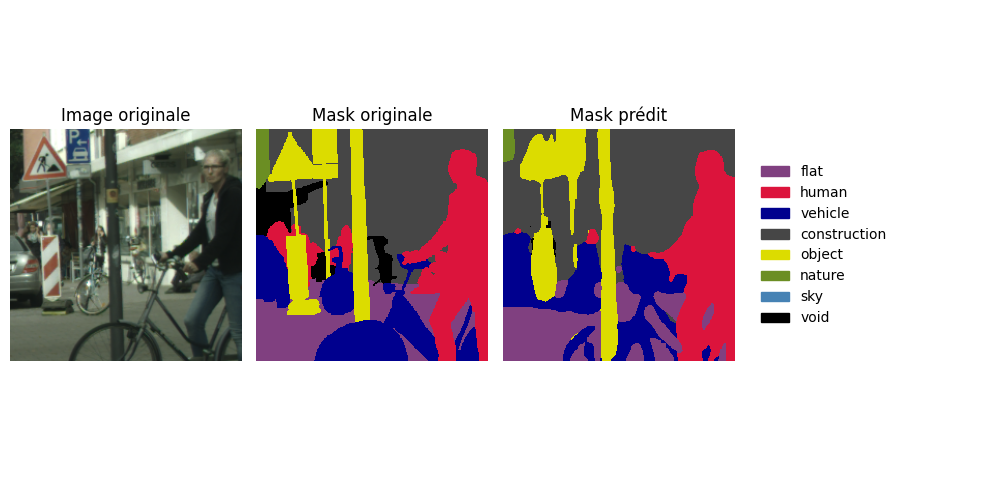

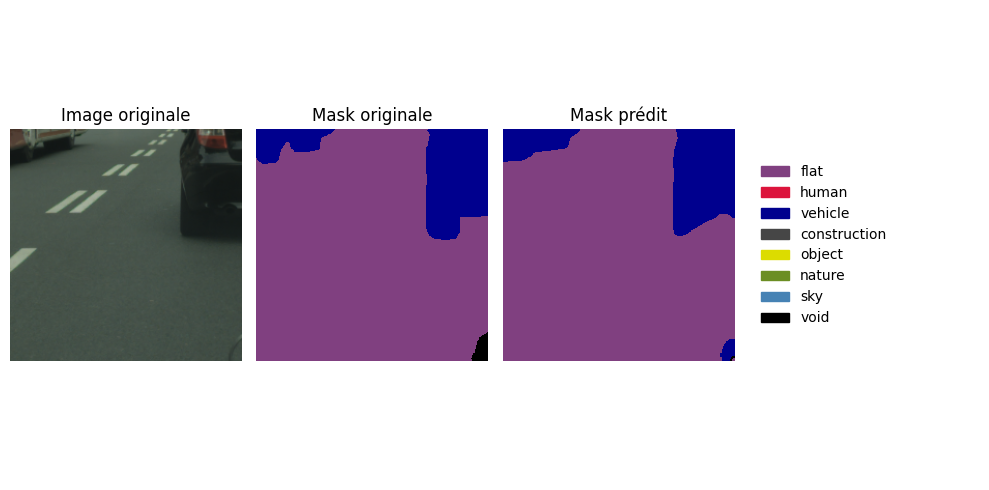

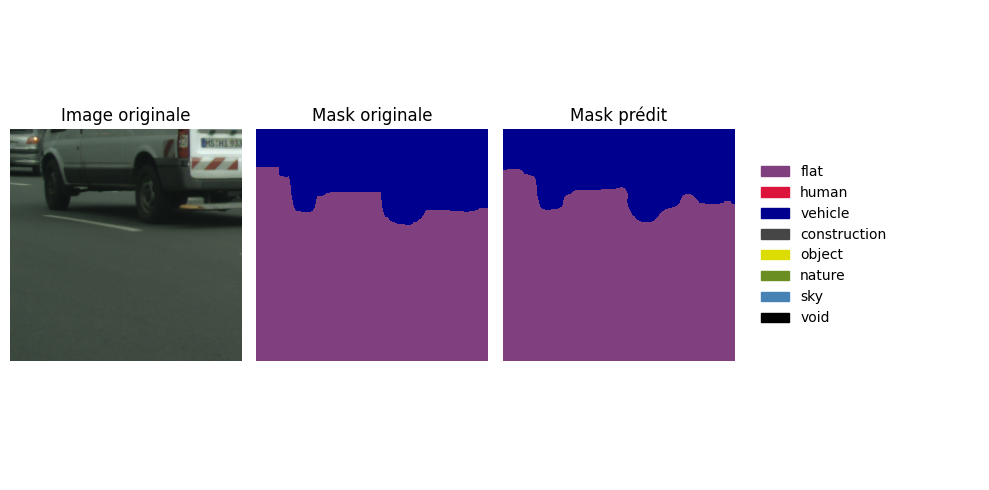

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


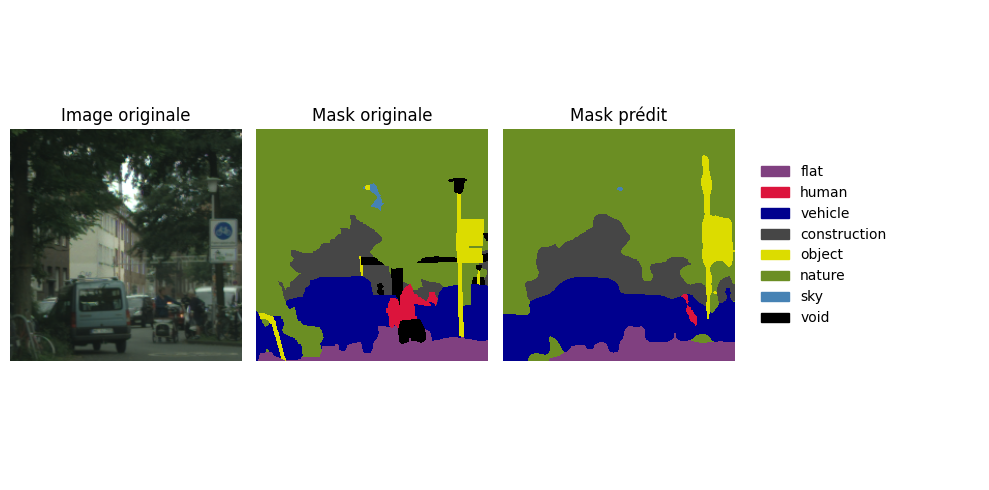

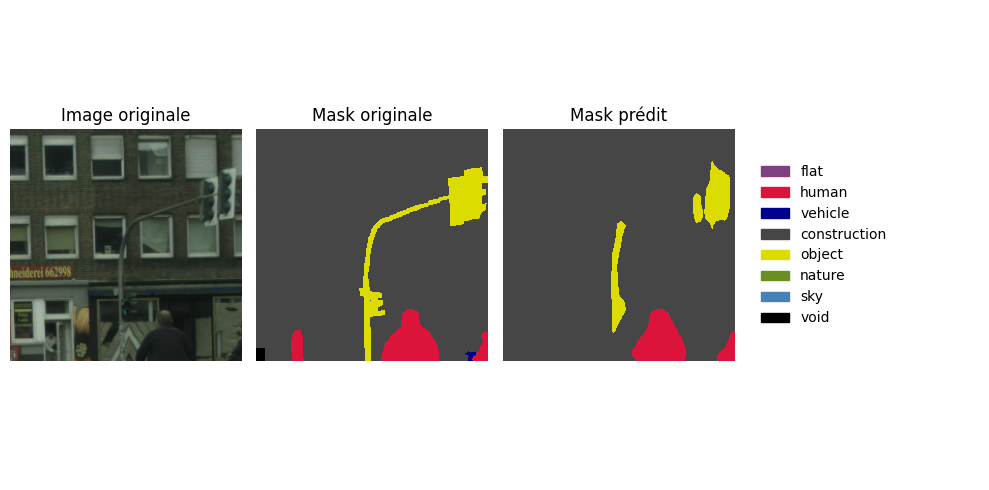

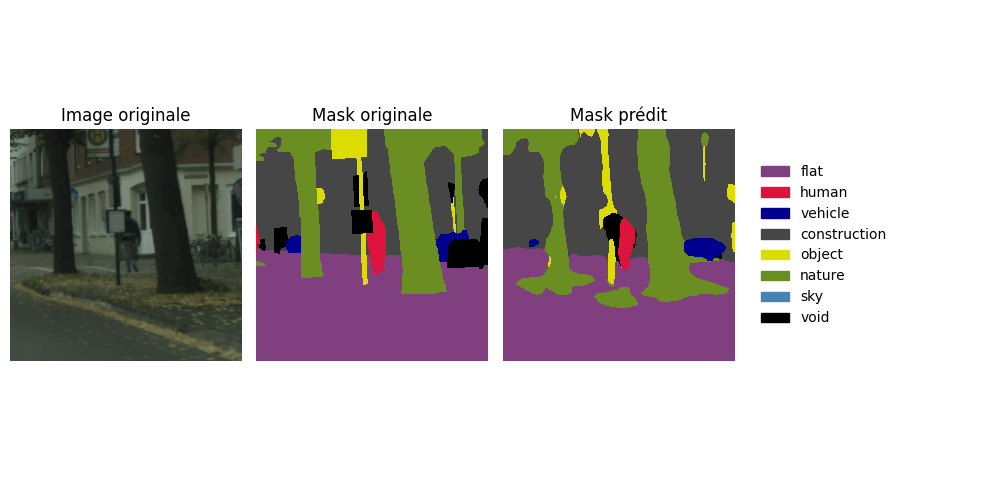

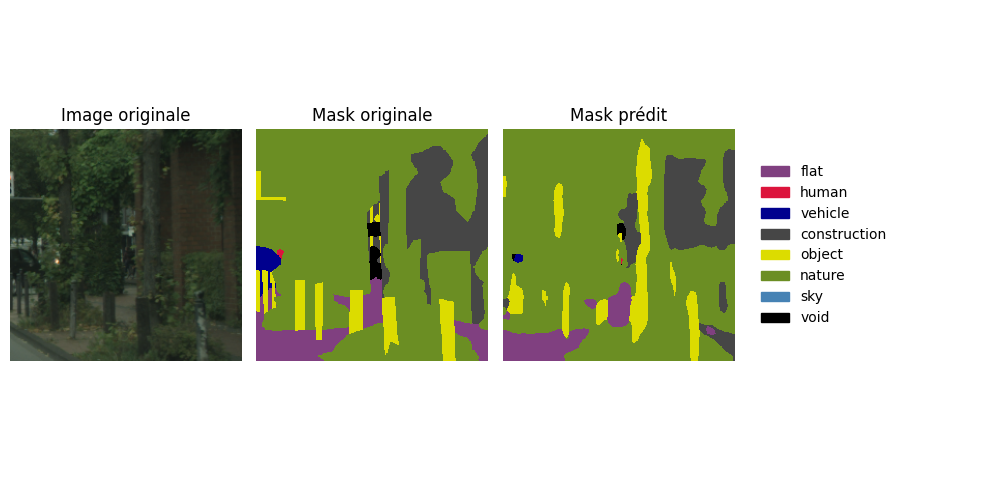

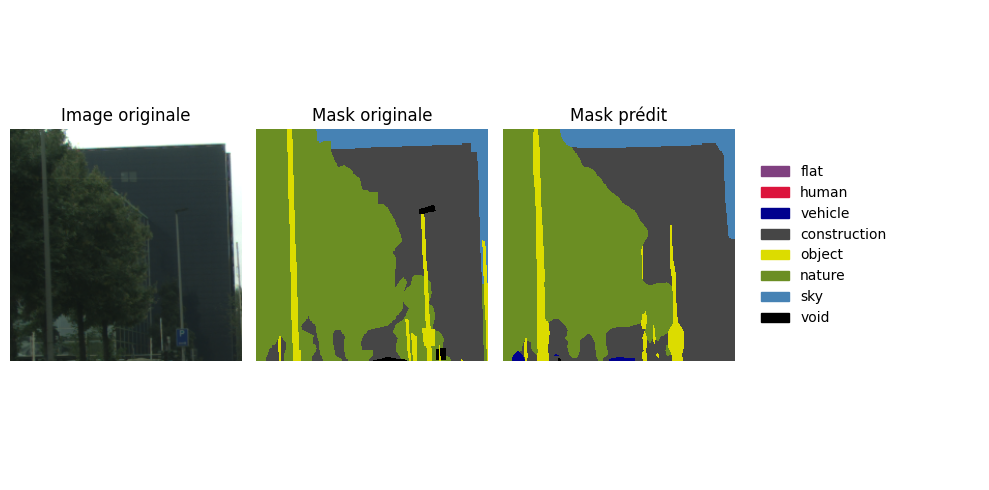

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


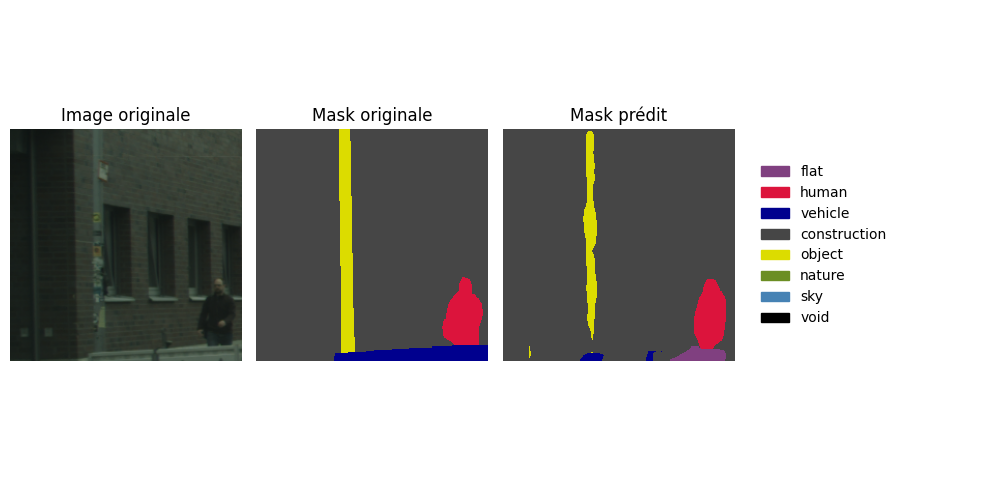

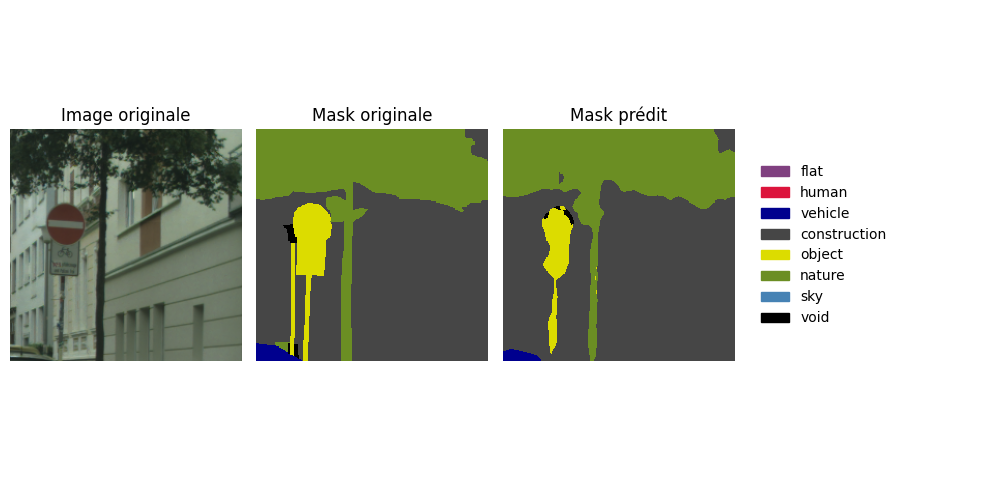

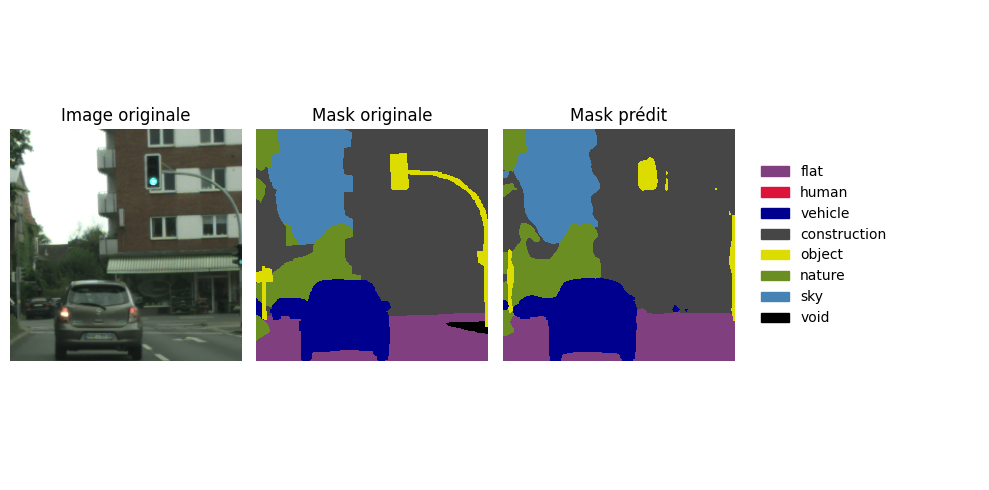

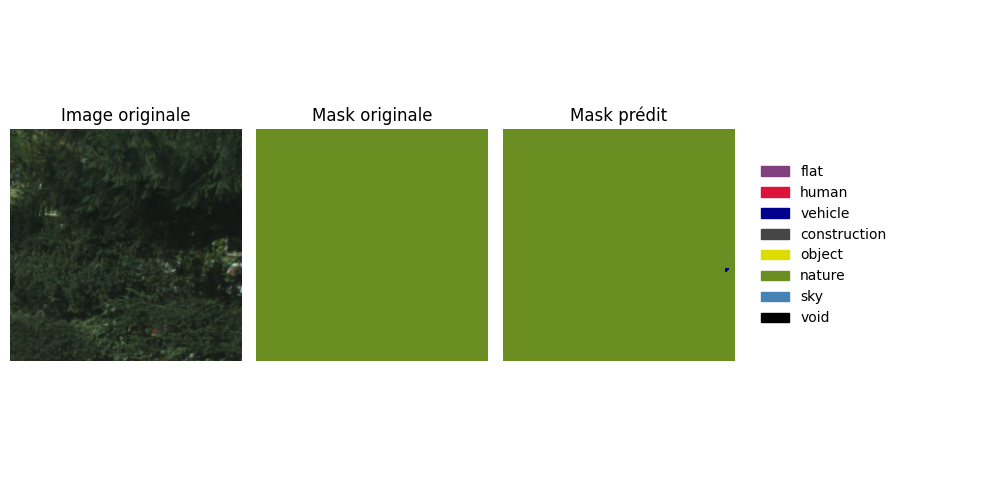

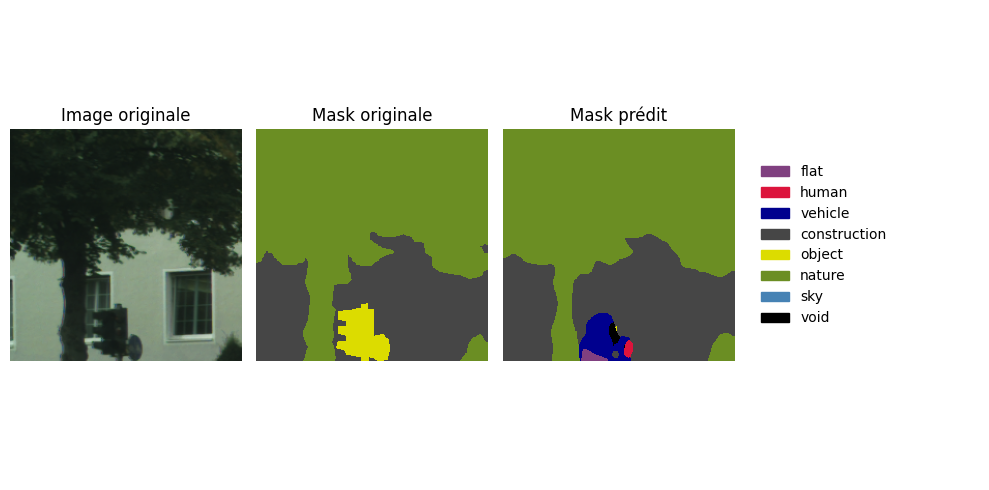

In [98]:
for batch, masks in test_ds.take(4):
    preds = final_model.predict(batch)
    pred_masks = np.argmax(preds, axis=-1)
    batch_np = batch.numpy()
    masks_np = masks.numpy()

    for i in range(5):
        display_prediction(batch_np[i], masks_np[i], pred_masks[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
y_true shape: (25088000,) y_pred shape: (25088000,)


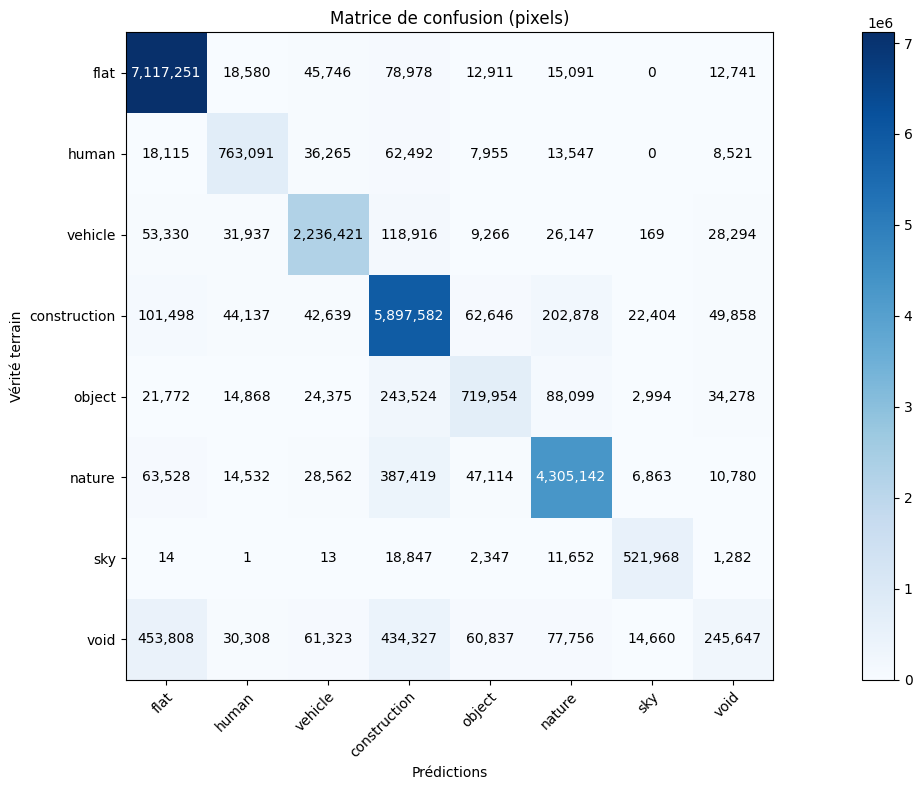

In [99]:
df_summary_fm = plot_confusion_matrix(final_model, test_ds)

In [100]:
df_summary_fm.sort_values(by="Accuracy (%)", ascending=False, inplace=True)
df_summary_fm.reset_index(drop=True, inplace=True)
display(df_summary_fm)

Group  Total Pixels  Correct Pixels  Accuracy (%)
0          flat       7301298         7117251     97.479256
1           sky        556124          521968     93.858204
2  construction       6423642         5897582     91.810565
3       vehicle       2504480         2236421     89.296820
4        nature       4863940         4305142     88.511413
5         human        909986          763091     83.857444
6        object       1149864          719954     62.612100
7          void       1378666          245647     17.817731

In [101]:
# MLFLOW
!pip install mlflow==2.22.0 -q
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

In [103]:
%%time
MLFLOW_TRACKING_URI = "https://mlflow.amadousy.dev"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("mit_segformer_model")

for x_batch, _ in test_ds.take(1):
    x_example = x_batch.numpy()
    break

with mlflow.start_run():
    mlflow.log_param("learning_rate", study.best_params["learning_rate"])
    mlflow.log_param("loss_type", study.best_params["loss_type"])
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("epochs", 30)

    mlflow.log_metric("mean_val_accuracy", np.max(history.history["val_accuracy"]))
    mlflow.log_metric("mean_val_loss", np.min(history.history["val_loss"]))
    mlflow.log_metric("val_mean_io_u_argmax", np.max(history.history["val_mean_io_u_argmax"]))

    mit_segformer_model_path = "mit_segformer_model.keras"
    final_model.save(mit_segformer_model_path)
    import os
    print(f"Size model: {os.path.getsize('mit_segformer_model.keras') / (1024**2)}")  # MB
    mlflow.log_artifact(mit_segformer_model_path, artifact_path="artifacts")

    signature = infer_signature(x_example, final_model.predict(x_example))

    mlflow.tensorflow.log_model(
        model=final_model,
        signature=signature,
        artifact_path="model",
        registered_model_name="mit_segformer_model"
    )

Size model: 153.93799877166748
🏃 View run industrious-ape-332 at: https://mlflow.amadousy.dev/#/experiments/23/runs/d6e5416b17244779b65bbb5642c01b53
🧪 View experiment at: https://mlflow.amadousy.dev/#/experiments/23
CPU times: user 9.55 s, sys: 532 ms, total: 10.1 s
Wall time: 23.7 s


Tests sur des données sans masks

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


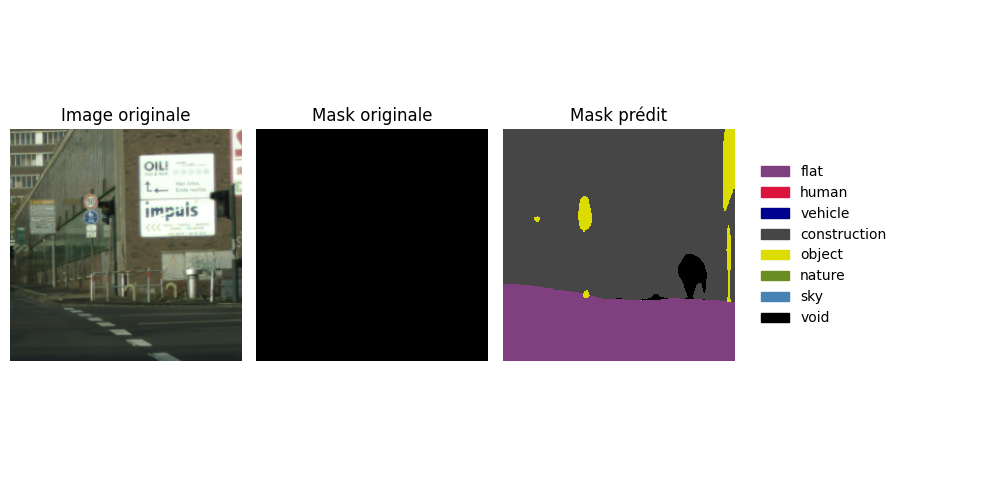

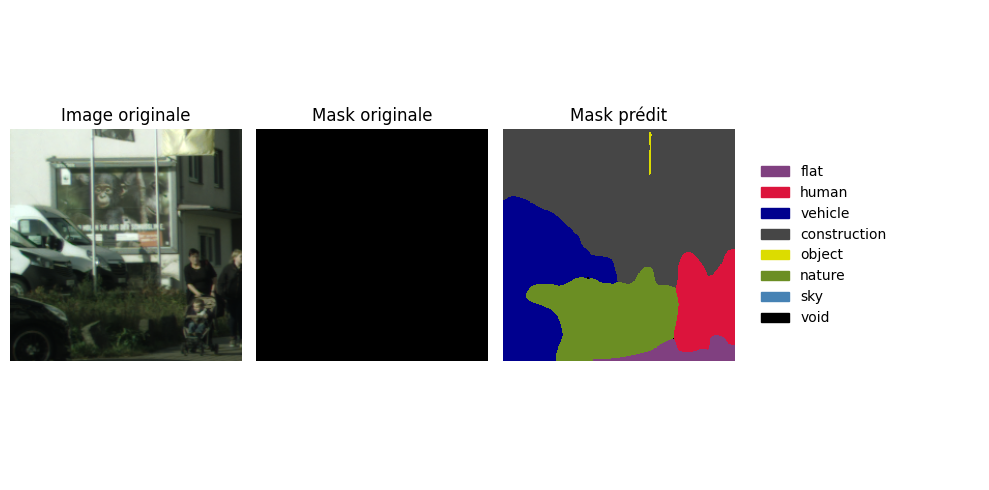

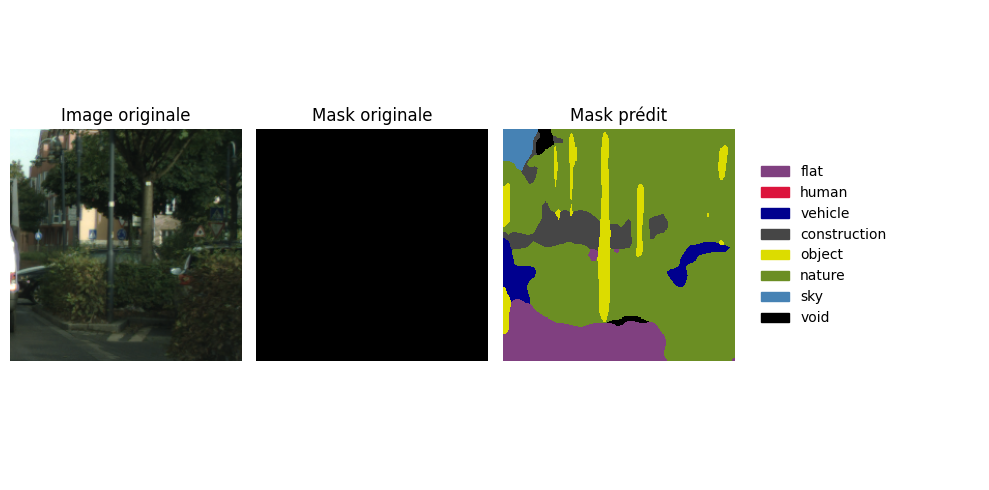

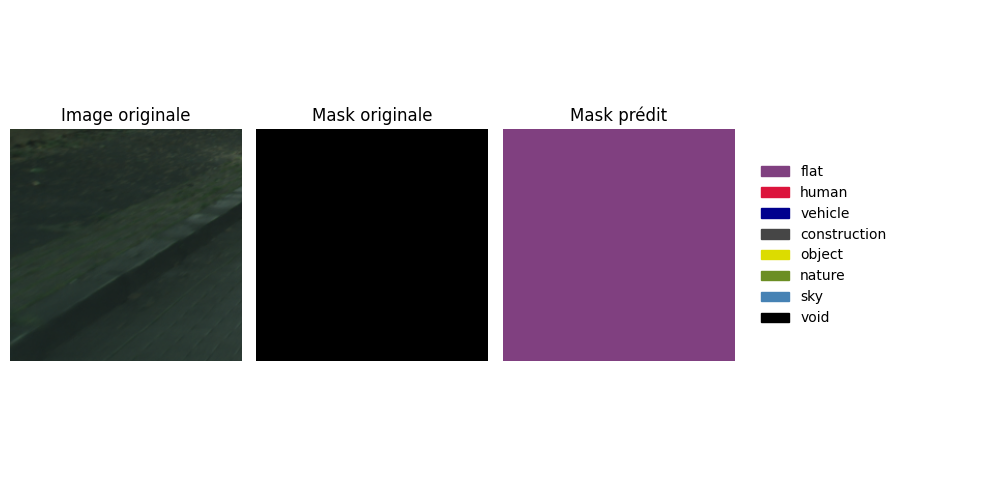

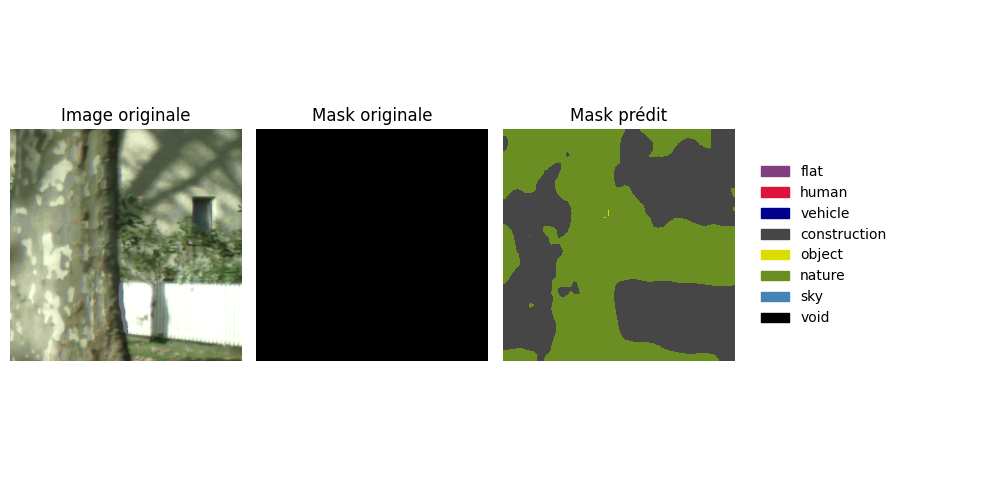

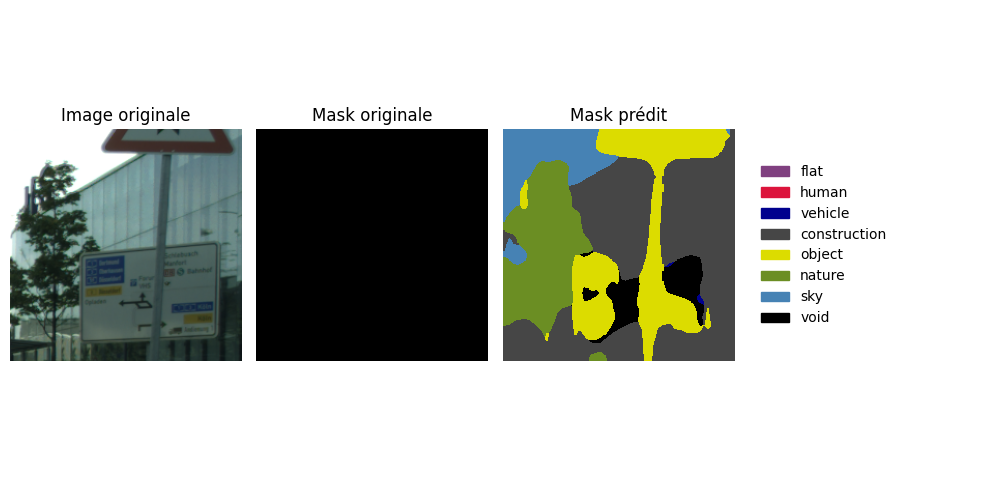

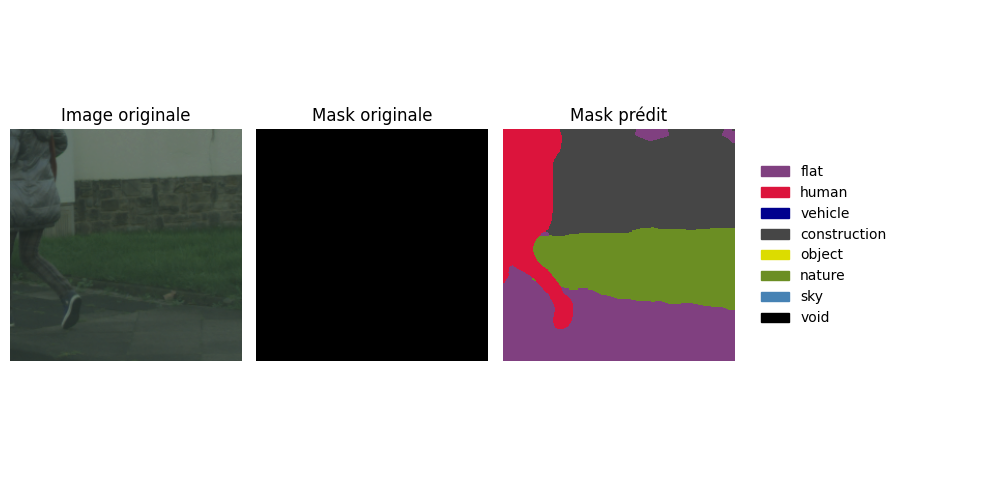

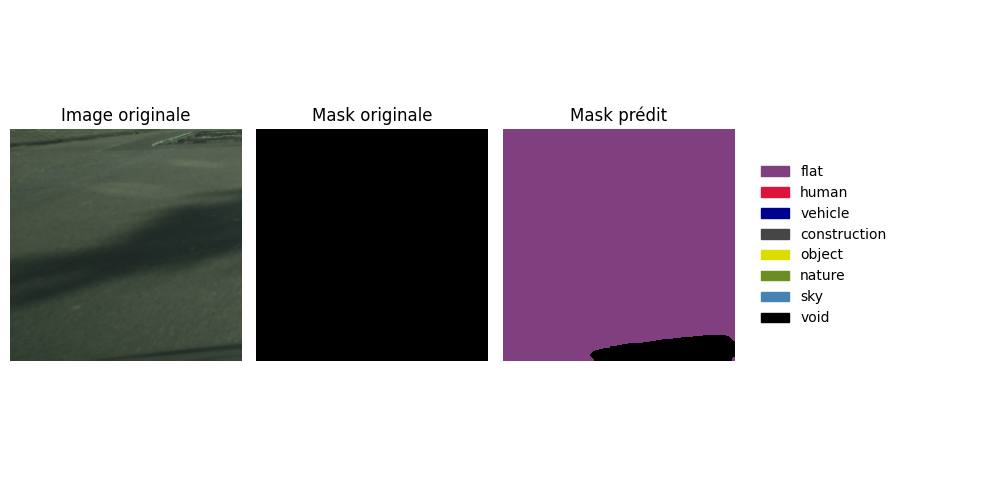

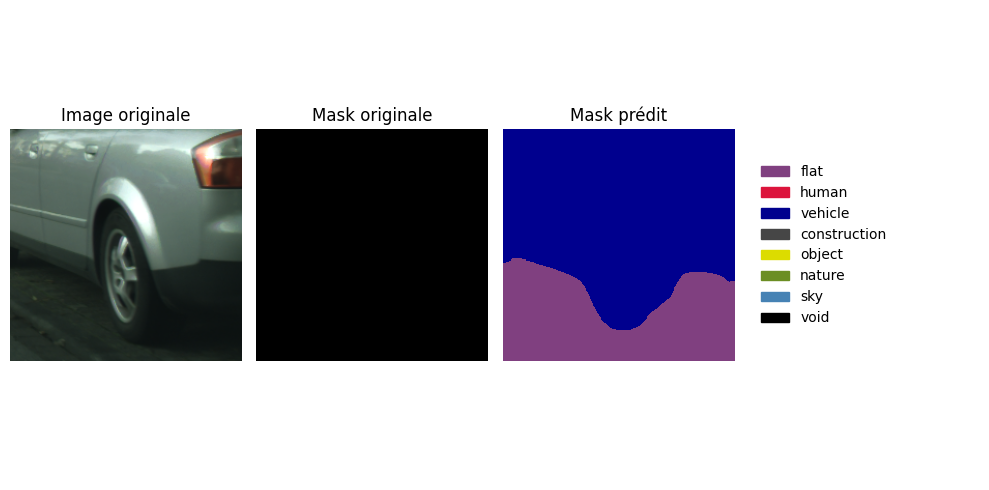

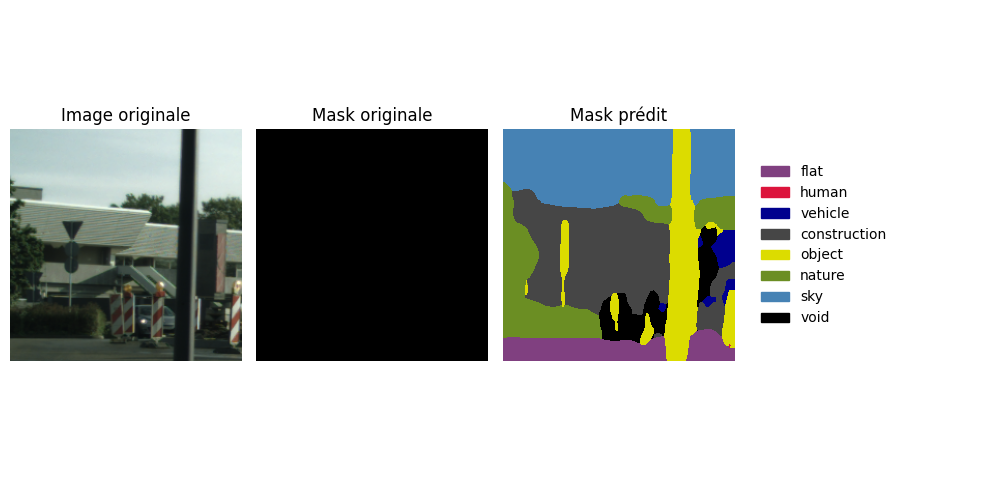

In [94]:
for batch, masks in test_wo_mask_ds.take(1):
    preds = final_model.predict(batch)
    pred_masks = np.argmax(preds, axis=-1)
    batch_np = batch.numpy()
    masks_np = masks.numpy()

    for i in range(10):
        display_prediction(batch_np[i], masks_np[i], pred_masks[i])

In [95]:
end_time = time.time()
print(f"Execution time={end_time-init_time} seconds")

Execution time=10915.758697986603 seconds
